# Limpieza de datos

In [268]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

from collections import Counter
import requests

In [269]:
sns.set()

with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("impuestos.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

Primero vemos el dataframe que se nos provee con la función **read_csv** : 

In [270]:
df = pd.read_csv("impuestos.csv")
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


Vemos que con el comando **info()** tenemos la información completa del dataframe. Algunos features como por ejemplo: barrio, trabajo, etc tiene como tipo de dato *object* (default por el programa), por lo que deberemos cambiar estos tipos de datos.

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

In [272]:
(df.isnull().mean() * 100).to_frame('porcentaje nulls')

,porcentaje nulls
anios_estudiados,0.000000
barrio,1.790486
categoria_de_trabajo,5.638647
edad,0.000000
educacion_alcanzada,0.000000
estado_marital,0.000000
ganancia_perdida_declarada_bolsa_argentina,0.000000
genero,0.000000
horas_trabajo_registradas,0.000000
religion,0.000000


 Para este trabajo optamos por no eliminar las filas duplicadas ya que consideramos que seria información relevante para nuesto análisis exploratorio. Esto se debe a que no tenemos información que identifique una entrada de otra. Entonces el comando **drop_duplicates()** sería innecesario.

 Por otro lado, analizaremos si los features numéricos y nos aseguramos que no contengan valores inválidos. Por ejemplo, para la *edad* el valor no puede ser negativo y supusimos que aquellos mayores a 17 son considerados válidos. En el caso particular de *ganancia_perdida_declarada_bolsa_argentina* se admite número negativo ya que representa perdida. Vemos así que todos las columnas cuentan con información válida.

In [273]:
df.describe()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456,0.240810
std,2.664488,13.640433,7408.986951,12.347429,0.427581
min,1.000000,17.000000,-4356.000000,1.000000,0.000000
25%,13.000000,28.000000,0.000000,40.000000,0.000000
50%,14.000000,37.000000,0.000000,40.000000,0.000000
75%,16.000000,48.000000,0.000000,45.000000,0.000000
max,20.000000,90.000000,99999.000000,99.000000,1.000000


La columna *barrio* contiene algunos valores en mayúscula y otros en minúscula, por lo que por comodidad pasaremos todo a un mismo formato. Por otro lado algunas filas no cuentan con información, decidimos agregar una nueva categoria llamada *otro*.

In [274]:
df['barrio'] = df['barrio'].str.lower()
df['barrio'].replace({None: "otro"}, inplace=True)

Vemos que las columnas *Categoria de trabajo* y *Trabajo* tienen multiples valores nulls en las mismas filas:

In [275]:
print("Cantidad de filas con 'categoria de trabajo' y 'trabajo' null: ", 
     ((df["categoria_de_trabajo"].isnull()) & (df["trabajo"].isnull())).sum())

Cantidad de filas con 'categoria de trabajo' y 'trabajo' null:  1836


Para la categoría de trabajo creamos una nueva opción llamada "no especificada", ya que consideramos que una persona que no completo este campo podría aun así pertenecer a una de las categorias indicadas.

Operamos de manera similar con la columna *trabajo*.

In [276]:
df['categoria_de_trabajo'].replace({None: "no_especificada"}, inplace=True)
df['trabajo'].replace({None: "no_especificado"}, inplace=True)

Algunas columnas como por ejemplo *categoria_de_trabajo* contienen algunos valores mal escritos. Procederemos a arreglarlos:

In [277]:
df['categoria_de_trabajo'].replace({"monotibutista": "monotributista"}, inplace=True)
df['barrio'].replace({"cilla riachuelo": "villa riachuelo"}, inplace=True)

La columna *tiene_alto_valor_adquisitivo* es de tipo int64 cuando solo toma los valores 0 o 1, por lo que la cambiaremos a *bool* que consideramos más acorde.

In [278]:
df['tiene_alto_valor_adquisitivo'] = df['tiene_alto_valor_adquisitivo'].astype(np.bool)

Vemos aquellas columnas con tipo *object* cuales son las que tienen un valor único. En nuestro caso ninguna de ellas, por lo que todas las columnas serán de tipo *category*.

In [279]:
df.select_dtypes(include=['object']).nunique()

barrio                     42
categoria_de_trabajo        9
educacion_alcanzada        16
estado_marital              7
genero                      2
religion                    5
rol_familiar_registrado     6
trabajo                    15
dtype: int64

In [280]:
df['barrio'] = df['barrio'].astype("category")
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].astype("category")
df['educacion_alcanzada'] = df['educacion_alcanzada'].astype("category")
df['estado_marital'] = df['estado_marital'].astype("category")
df['genero'] = df['genero'].astype("category")
df['religion'] = df['religion'].astype("category")
df['rol_familiar_registrado'] = df['rol_familiar_registrado'].astype("category")
df['trabajo'] = df['trabajo'].astype("category")

El dataframe nos queda entonces de la siguiente manera:

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   anios_estudiados                            32561 non-null  int64   
 1   barrio                                      32561 non-null  category
 2   categoria_de_trabajo                        32561 non-null  category
 3   edad                                        32561 non-null  int64   
 4   educacion_alcanzada                         32561 non-null  category
 5   estado_marital                              32561 non-null  category
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64   
 7   genero                                      32561 non-null  category
 8   horas_trabajo_registradas                   32561 non-null  int64   
 9   religion                                    32561 non-null  category
 10

# Análisis de datos

Para el análisis de los datos provistos decidimos realizar los siguientes pasos:


1.   Graficar las distribuciones de las distintas columnas para visualizar así con que estamos trabajando,
2.   Relacionar cada columna con la variable objetivo para obtener conclusiones,
3.   En base a las conclusiones obtenidas en el punto anterior, elegir aquella columna que consideramos que mejor estima la variable objetivo,
4.   Repetir el paso 2 hasta que la subdivisión ya no sea considerable

## Distribuciones de los datos

Arrancaremos graficando las distintas distribuciones de todas las columnas para ver con que datos nos encontramos:

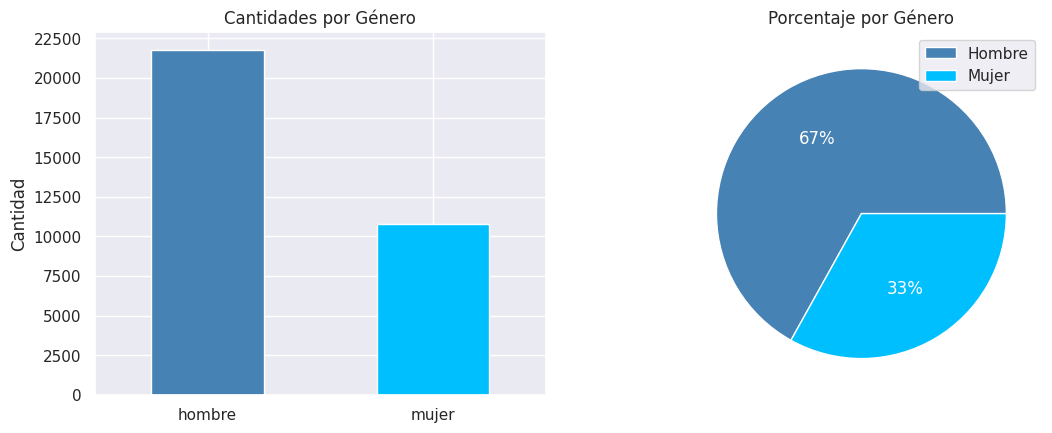

In [282]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df.genero.value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'deepskyblue'])
axes[0].set_title("Cantidades por Género")
axes[0].set_ylabel("Cantidad")
axes[0].set_yticks(range(0,25000,2500))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

df["genero"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['steelblue', 'deepskyblue'], textprops={'color':"w"},ax=axes[1]
)
axes[1].legend(labels=['Hombre','Mujer'])
axes[1].set_title("Porcentaje por Género")
axes[1].set_ylabel('')

plt.show()

Vemos que la mayoría son hombres: del total 2/3 son hombres y 1/3 son mujeres.

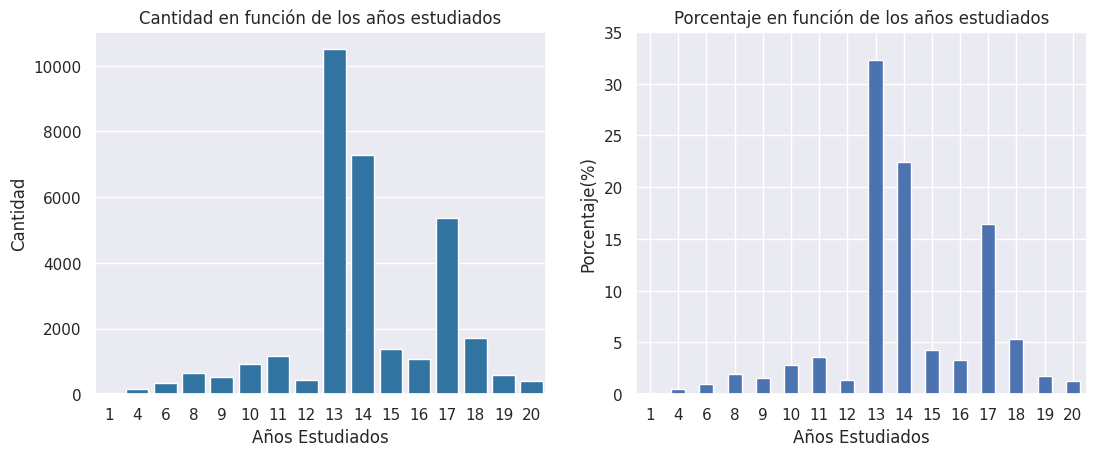

In [283]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8 * 1], dpi=100)
sns.countplot(x='anios_estudiados',data=df, color="tab:blue", ax=axes[0])
axes[0].set_title("Cantidad en función de los años estudiados")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Años Estudiados")

df.anios_estudiados.value_counts().sort_index().div(df.pipe(len)).mul(100).plot(
    kind='bar', ax=axes[1]
)
axes[1].set_title("Porcentaje en función de los años estudiados")
axes[1].set_ylabel("Porcentaje(%)")
axes[1].set_xlabel("Años Estudiados")
axes[1].set_yticks(range(0,40,5))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.grid(True)
plt.show()

Vemos que la mayor parte de las personas tiene entre 13 y 18 años estudiados.

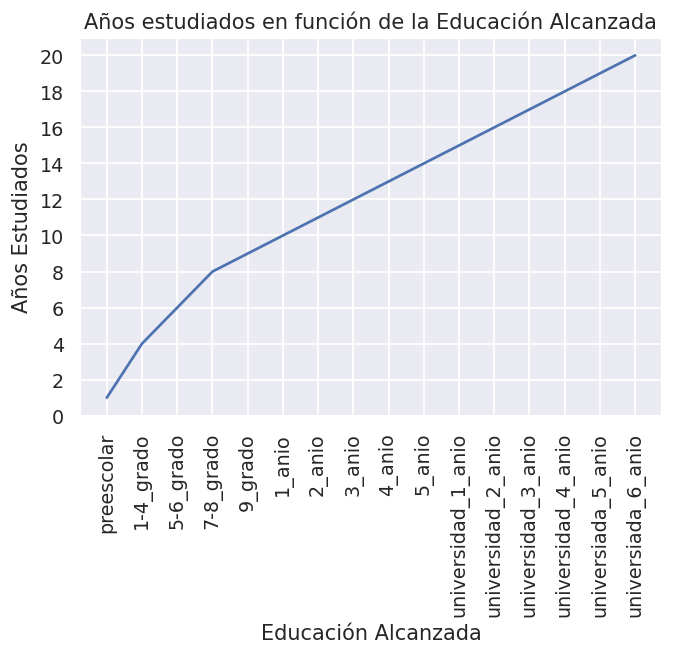

In [284]:
df['educacion_alcanzada'] = pd.Categorical(df['educacion_alcanzada'], categories=[
    'preescolar', '1-4_grado', '5-6_grado',
    '7-8_grado', '9_grado', '1_anio',
    '2_anio', '3_anio', '4_anio',
    '5_anio', 'universidad_1_anio',
    'universidad_2_anio', 'universidad_3_anio',
    'universidad_4_anio', 'universiada_5_anio',
    'universiada_6_anio'
], ordered=True)

plt.figure(dpi=125)
ax = sns.lineplot(
    data=df, 
    x='educacion_alcanzada',
    y='anios_estudiados',
    sort = True,
)
ax.set_title("Años estudiados en función de la Educación Alcanzada")
ax.set_ylabel("Años Estudiados")
ax.set_xlabel("Educación Alcanzada")
ax.set_yticks(range(0,21,2))
plt.xticks(rotation=90)
plt.show()

Por otro lado, nos dimos cuenta que tanto la columna *anios_estudiados* y *educacion_alcanzada* se relacionaban linealmente. Tener en cuenta que si bien la relación no parece lineal al principio, esto se debe a que las categorias iniciales del eje x agrupan multiples valores de años estudiados. Decidimos entonces eliminar la columna *educacion_alcanzada*, ya que consideramos que no nos aporta información nueva.

In [285]:
del(df['educacion_alcanzada'])

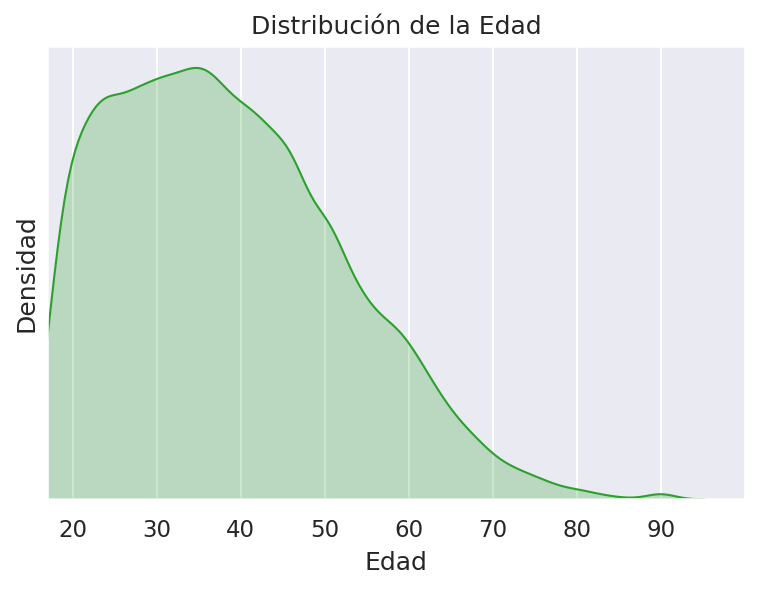

In [286]:
plt.figure(dpi=150)
sns.kdeplot(data=df.edad, fill=True, color="tab:green")
plt.ylabel("Densidad")
plt.xlabel("Edad")
plt.title("Distribución de la Edad")
plt.xticks(range(0, 100, 10))
plt.xlim(17, 100)
plt.yticks([], [])
plt.show()

Vemos que la mayoria de las personas se encuentra en el rango de entre 20 y 40 años.

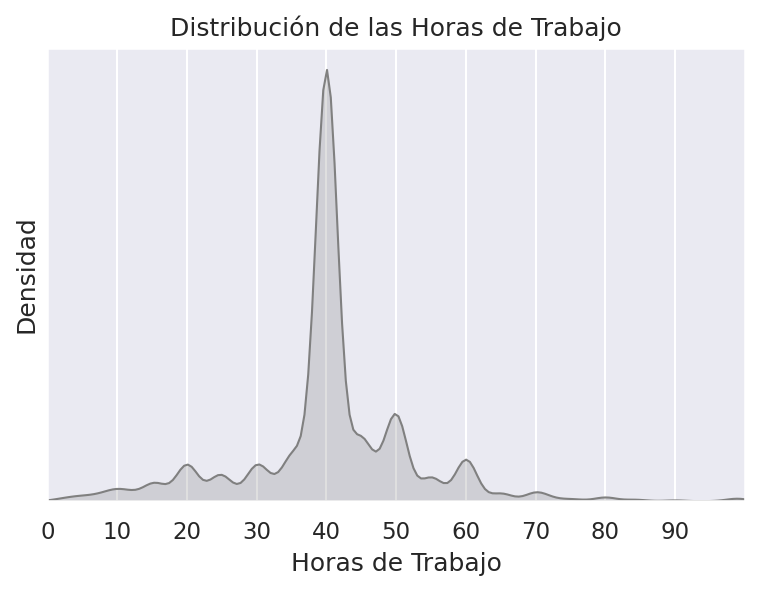

In [287]:
plt.figure(dpi=150)
sns.kdeplot(data=df.horas_trabajo_registradas, fill=True, color="grey")
plt.title("Distribución de las Horas de Trabajo")
plt.ylabel("Densidad")
plt.xlabel("Horas de Trabajo")
plt.xticks(range(0, 100, 10))
plt.xlim(0, 100)
plt.yticks([], [])
plt.show()

Vemos que la mayoría de las personas trabaja 40 horas por semana.

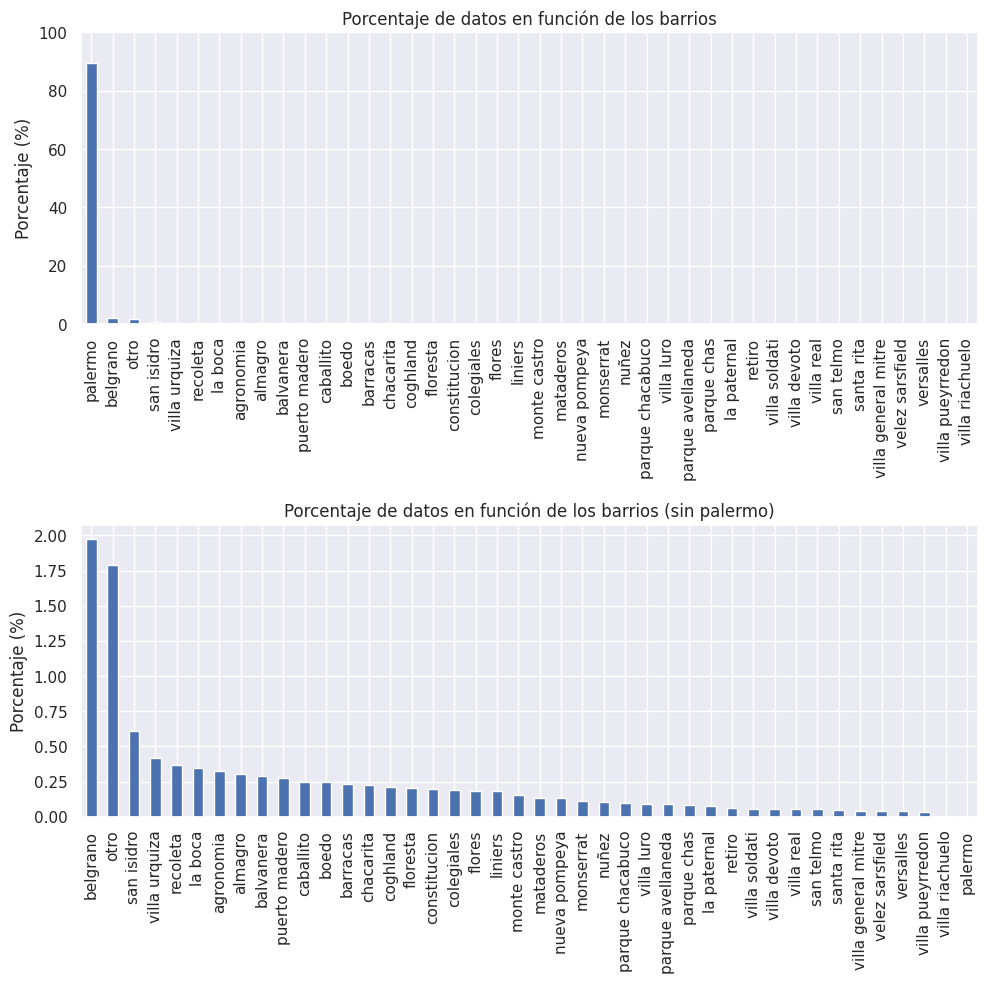

In [288]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[6.4 * 2, 4.8 * 2.4], dpi=100)
fig.tight_layout(pad=10)

df.barrio.value_counts().div(df.pipe(len)).mul(100).plot(
    kind='bar', ax=axes[0]
)
axes[0].set_title("Porcentaje de datos en función de los barrios")
axes[0].set_ylabel("Porcentaje (%)")
axes[0].set_yticks(range(0,110,20))

df_sin_palermo = df[df["barrio"] != "palermo"]
df_sin_palermo.barrio.value_counts().div(df.pipe(len)).mul(100).plot(
    kind='bar', ax=axes[1]
)
axes[1].set_title("Porcentaje de datos en función de los barrios (sin palermo)")
axes[1].set_ylabel("Porcentaje (%)")

plt.sca(axes[0])
plt.xticks(rotation=90)
plt.sca(axes[1])
plt.xticks(rotation=90)
plt.show()

Podemos ver que cerca del 90% de las personas viven en el barrio *Palermo*. Ademas se ve que muchos de los barrios tienen una cantidad poco significativa. En el segundo gráfico podemos ver que solo 2 casos superan el 1% de los datos, de modo que se evidencia la poca información que nos proporcionan.

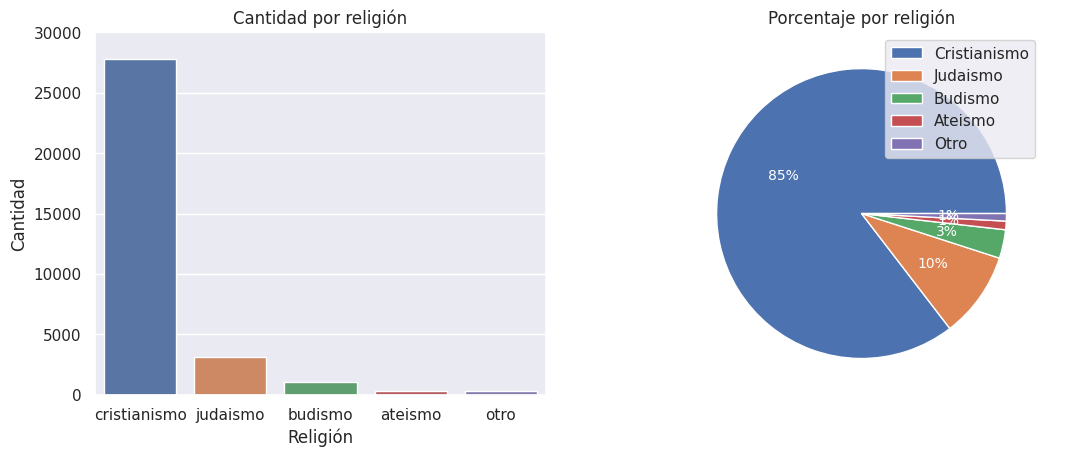

In [289]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

sns.countplot(x='religion',data=df, ax=axes[0], order=['cristianismo', 'judaismo', 'budismo', 'ateismo', 'otro'])
axes[0].set_xlabel("Religión")
axes[0].set_ylabel("Cantidad")
axes[0].set_title("Cantidad por religión")
axes[0].set_yticks(range(0,31000,5000))

df["religion"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},ax=axes[1], colors= ['C0', 'C1', 'g', 'r', 'C4'], fontsize=10
)
axes[1].legend(labels=['Cristianismo','Judaismo', 'Budismo', 'Ateismo', 'Otro'])
axes[1].set_title("Porcentaje por religión")
axes[1].set_ylabel("")

plt.show()

Similar a como ocurre con los barrios, el cristianismo supera en cantidad de datos ampliamente a las demás religiones. 

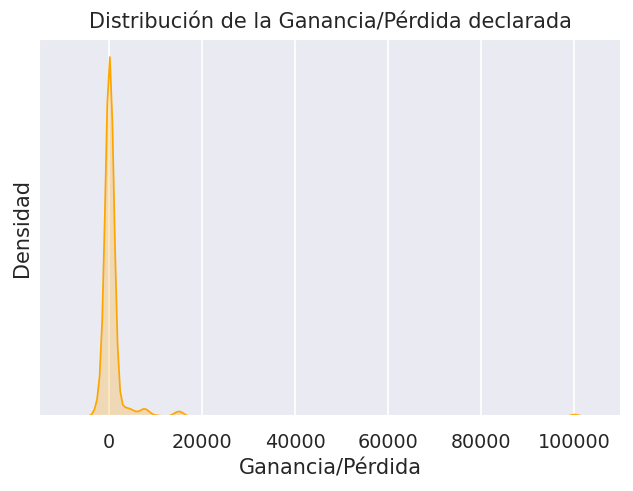

In [290]:
plt.figure(dpi=125)
sns.kdeplot(data=df.ganancia_perdida_declarada_bolsa_argentina, fill=True, color="orange")

plt.ylabel("Densidad")
plt.xlabel("Ganancia/Pérdida")
plt.title("Distribución de la Ganancia/Pérdida declarada")
plt.xlim(-15000, 110000)
plt.yticks([], [])
plt.show()

Del gráfico anterior se puede observar que la mayor parte de las personas no tienen ganancias ni pérdidas declaradas

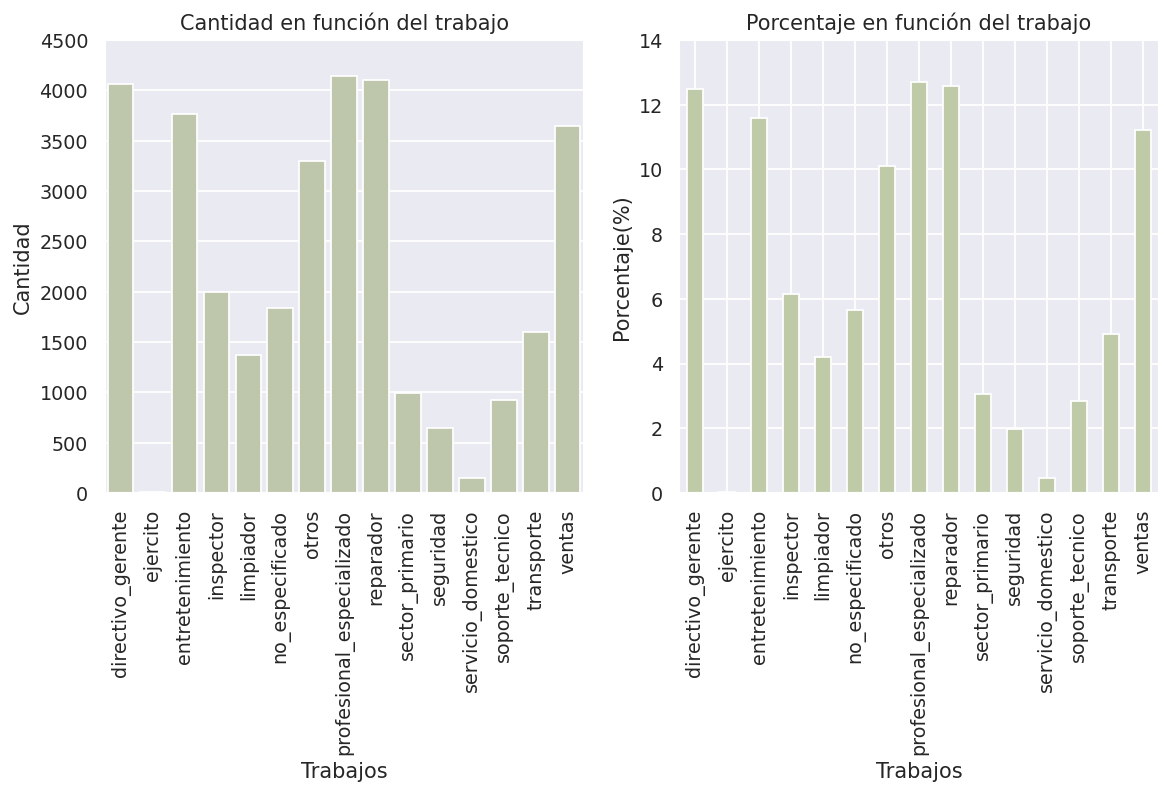

In [291]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 1.7, 4.8 * 1], dpi=125)
sns.countplot(x='trabajo',data=df, color="#BFCBA8", ax=axes[0])
axes[0].set_title("Cantidad en función del trabajo")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Trabajos")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_yticks(range(0,5000,500))

df.trabajo.value_counts().sort_index().div(df.pipe(len)).mul(100).plot(
    kind='bar', ax=axes[1], color = '#BFCBA8'
)
axes[1].set_title("Porcentaje en función del trabajo")
axes[1].set_ylabel("Porcentaje(%)")
axes[1].set_xlabel("Trabajos")
axes[1].set_yticks(range(0,16,2))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

Vemos que la distribución es variada: vemos trabajos como *directivo gerente*, *profesional especializado*, *reparador*, y *ventas* con cantidades de casos superiores al 10%; trabajos intermedios como *inspector* y *transporte*, y trabajos con muy pocos datos como *ejercito* y *servicio doméstico*.

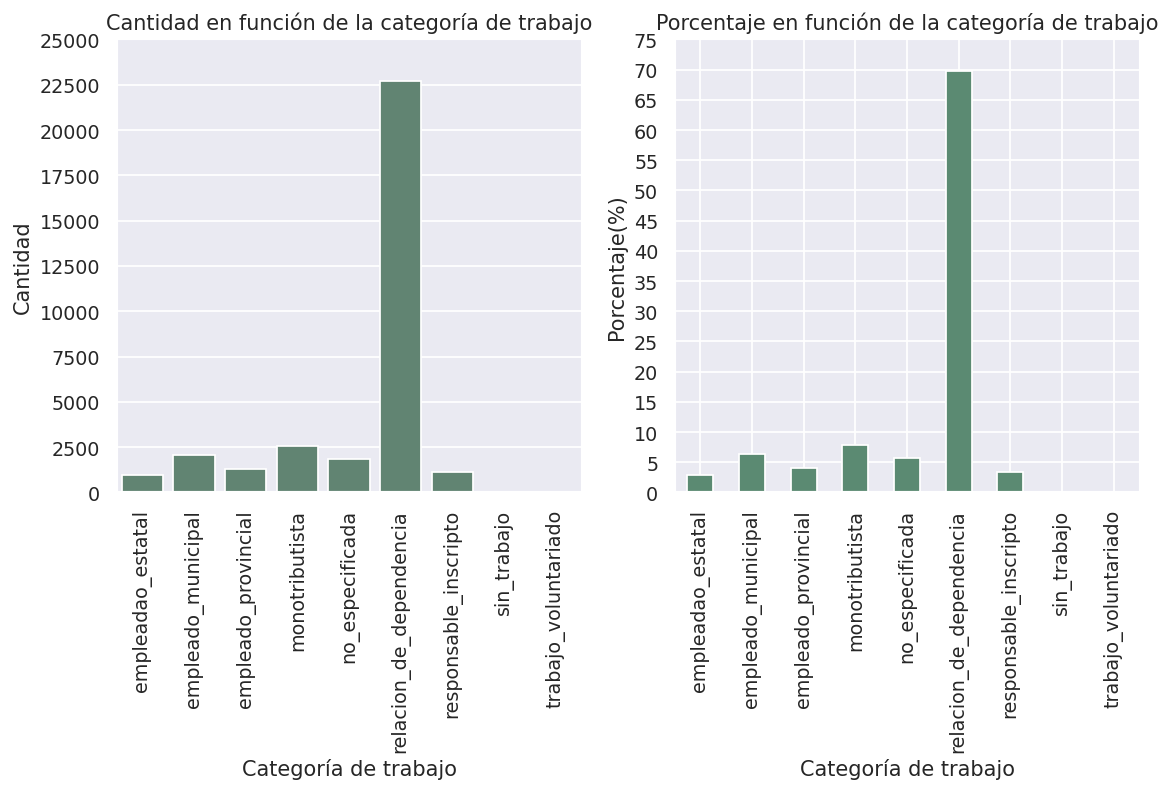

In [292]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 1.65, 4.8 * 1], dpi=125)
sns.countplot(x='categoria_de_trabajo',data=df, color="#5B8A72", ax=axes[0])
axes[0].set_title("Cantidad en función de la categoría de trabajo")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Categoría de trabajo")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_yticks(range(0,26000,2500))

df.categoria_de_trabajo.value_counts().sort_index().div(df.pipe(len)).mul(100).plot(
    kind='bar', ax=axes[1], color = '#5B8A72'
)
axes[1].set_title("Porcentaje en función de la categoría de trabajo")
axes[1].set_ylabel("Porcentaje(%)")
axes[1].set_xlabel("Categoría de trabajo")
axes[1].set_yticks(range(0,80,5))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

A diferencia del caso anterior, la distribución no es variada. La categoría *relacion de dependencia* tiene la amplia mayoria de los casos. Ademas las categorias *sin trabajo* y *trabajo voluntario* no tienen prácticamente datos.


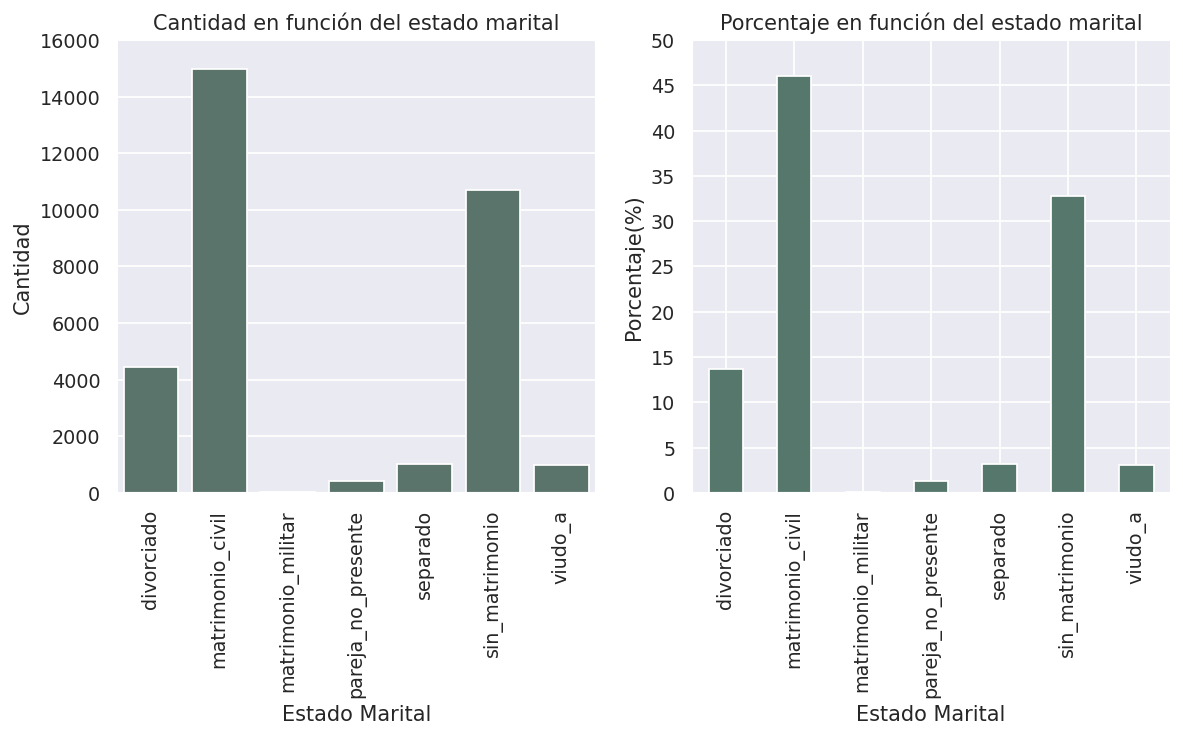

In [293]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 1.7, 4.8 * 1], dpi=125)
sns.countplot(x='estado_marital',data=df, color="#56776C", ax=axes[0])
axes[0].set_title("Cantidad en función del estado marital")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Estado Marital")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_yticks(range(0,17000,2000))

df.estado_marital.value_counts().sort_index().div(df.pipe(len)).mul(100).plot(
    kind='bar', ax=axes[1], color="#56776C"
)
axes[1].set_title("Porcentaje en función del estado marital")
axes[1].set_ylabel("Porcentaje(%)")
axes[1].set_xlabel("Estado Marital")
axes[1].set_yticks(range(0,55,5))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

Nuevamente una distribución variada: *sin matrimoni*o y *matrimonio civil* con la mayor parte de los casos, *divorciado* con una cantidad intermedia y el resto de las categorías con muy pocos datos.

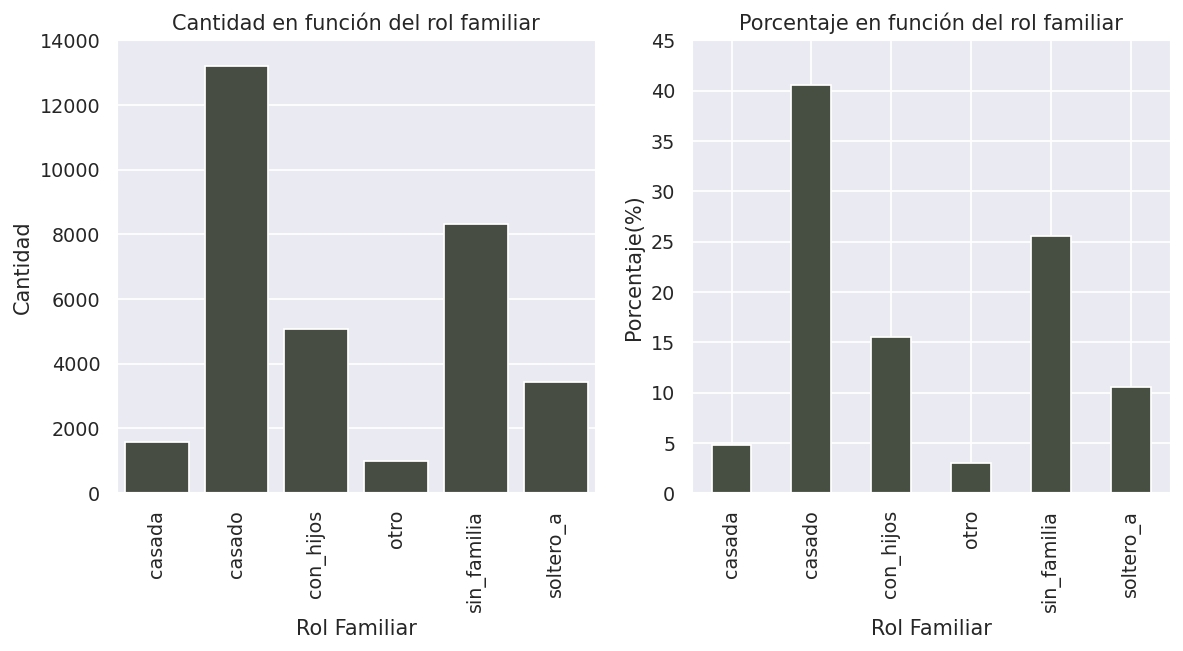

In [294]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 1.7, 4.8 * 1], dpi=125)
sns.countplot(x='rol_familiar_registrado',data=df, color="#464f41", ax=axes[0])
axes[0].set_title("Cantidad en función del rol familiar")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Rol Familiar")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_yticks(range(0,15000,2000))

df.rol_familiar_registrado.value_counts().sort_index().div(df.pipe(len)).mul(100).plot(
    kind='bar', ax=axes[1], color="#464f41"
)
axes[1].set_title("Porcentaje en función del rol familiar")
axes[1].set_ylabel("Porcentaje(%)")
axes[1].set_xlabel("Rol Familiar")
axes[1].set_yticks(range(0,46,5))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

Otra vez una distribución variada, con las categorias *sin familia* y *casado* con la mayoria de los casos.

Veamos si hay alguna correlación lineal entre las columnas numéricas:

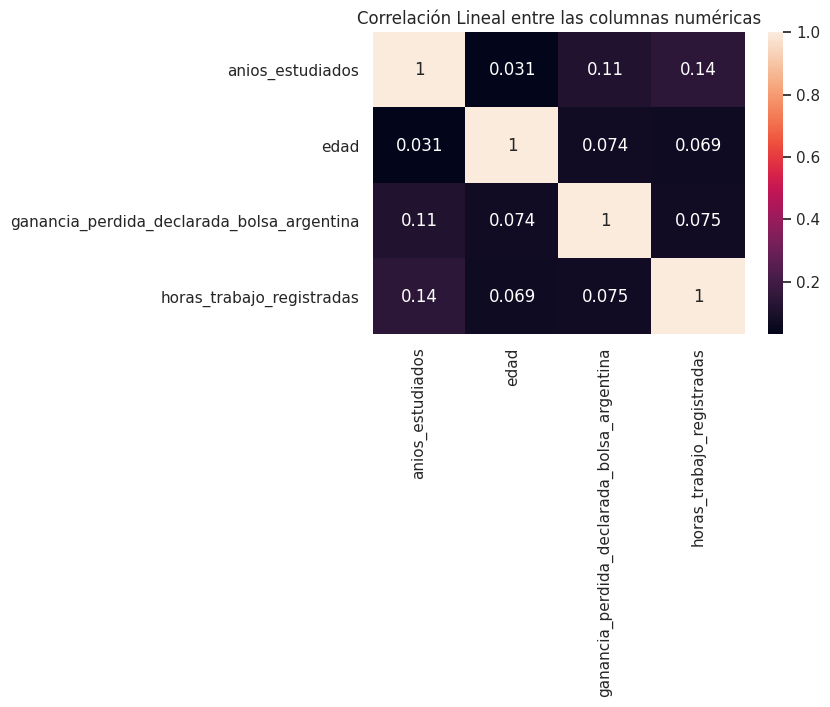

In [295]:
df_correlation = df.drop(columns=['tiene_alto_valor_adquisitivo'])
plt.figure(dpi=100)
sns.heatmap(df_correlation.corr(), annot=True)
plt.title("Correlación Lineal entre las columnas numéricas")
plt.show()

El gráfico nos muestra las distintas relaciones que tienen nuestras columnas numéricas. Si 0 representa que no hay ningun tipo de linealidad, y 1 representa una fuerte relación lineal entre las columnas, entonces vemos que ninguna de nuestras columnas numéricas existe alguna relación lineal. La máxima relación que encontramos es de 0.14 que aún así se puede considerar como que no hay relación. Por último podemos observar la diagonal de 1 debido a que es la relación que hay entre la columna y si misma.

Por último realizaremos un grafico que nos muestre la proporción de aquellas personas que tienen alto valor adquisitivo:

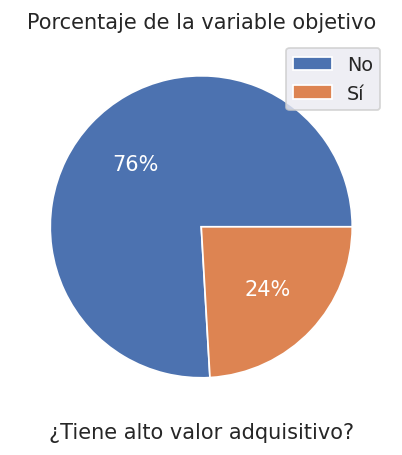

In [296]:
plt.figure(dpi=125)
df["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},
)
plt.legend(labels=['No','Sí'])
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.ylabel('')
plt.title("Porcentaje de la variable objetivo")
plt.show() 

Vemos que la mayoria de las personas entrevistadas no tienen alto valor adquisitivo. Nos basaremos en esta relación para los siguientes análisis, para así determinar si la información nos ayuda a llegar a una conclusión.

Entonces, conociendo las proporciones para saber si una persona tendrá alto valor adquisitivo, nos iremos preguntando si cada columna tiene una relación fuerte con la variable objetivo.

## Género vs Valor Adquisitivo

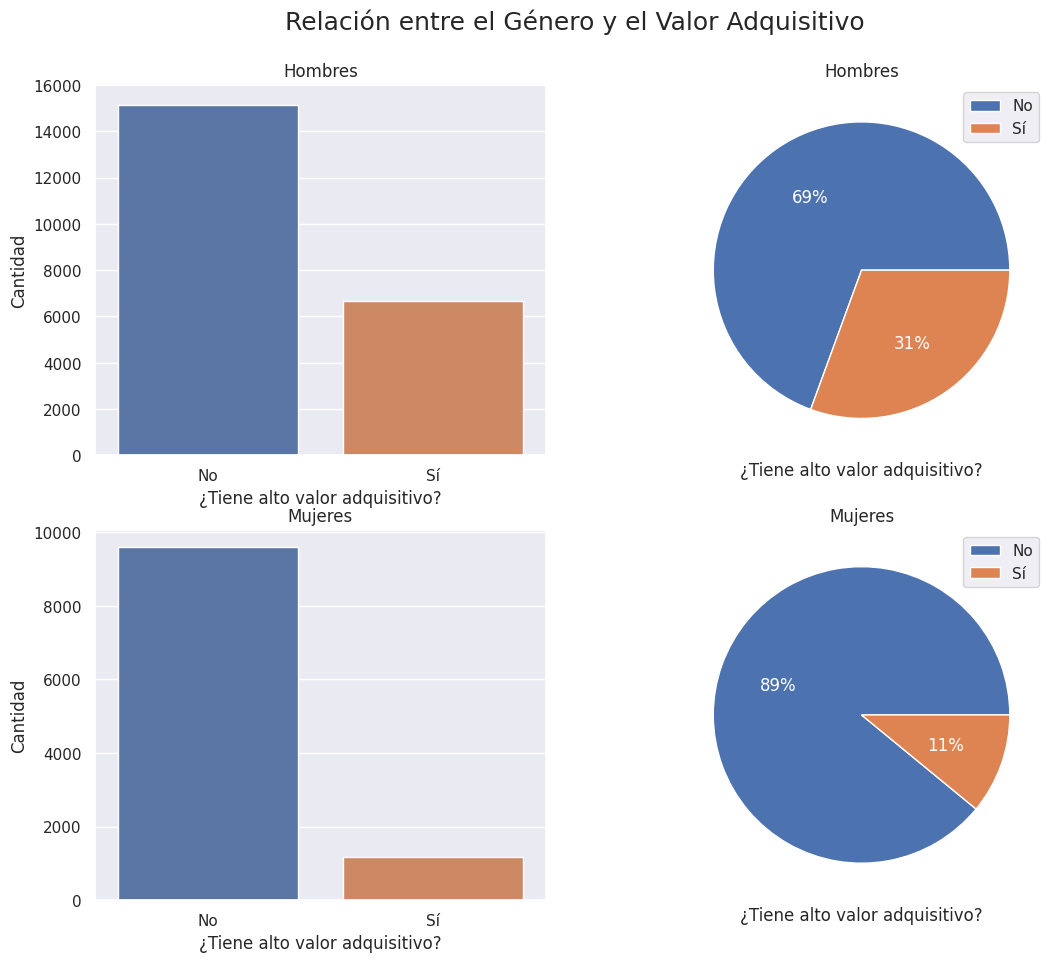

In [297]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[6.4 * 2, 4.8* 2.25], dpi=100)
fig.suptitle('Relación entre el Género y el Valor Adquisitivo', y=0.95, size=18)

df_men = df[df['genero'] == 'hombre']
df_women = df[df['genero'] == 'mujer']

sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_men,ax=axes[0][0])
axes[0][0].set_title("Hombres")
axes[0][0].set_ylabel("Cantidad")
axes[0][0].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[0][0].set_xticklabels(['No', 'Sí'])
axes[0][0].set_yticks(range(0,17000,2000))

df_men["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%',ax=axes[0][1], textprops={'color':"w"},
)
axes[0][1].set_ylabel('')
axes[0][1].legend(labels=['No','Sí'])
axes[0][1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[0][1].set_title("Hombres")

sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_women,ax=axes[1][0])
axes[1][0].set_title("Mujeres")
axes[1][0].set_ylabel("Cantidad")
axes[1][0].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1][0].set_xticklabels(['No', 'Sí'])
axes[1][0].set_yticks(range(0,11000,2000))

df_women["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%',ax=axes[1][1], textprops={'color':"w"},
)
axes[1][1].set_ylabel('')
axes[1][1].legend(labels=['No','Sí'])
axes[1][1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1][1].set_title("Mujeres")

plt.show()

Si separamos por género vemos que las mujeres tienen un mayor porcentajes de casos sin alto valor adquisitivo que los hombres. En el caso de los hombres la división es similar a la división general, por lo que no podemos sacar conclusiones.

Por lo que llegamos a nuestra primera conclusión: 
 - **El 89% de las mujeres entrevistadas NO tienen alto valor adquisitivo**

## Balance vs Valor Adquisitivo

Para hacer este análisis primero vamos a separar los valores posibles en tres categorias: 
1.   Negativo: aquellos que tienen perdidas declaradas
2.   Positivo: aquellos que tienen ganancias declaradas
3.   Neutro: aquellos que no declaran ni ganancia ni perdida


In [298]:
def balance(bolsa):
    if (bolsa > 0):
        return "Positivo"
    elif bolsa < 0:
        return "Negativo"
    else:
        return "Neutro"

df['balance'] = df["ganancia_perdida_declarada_bolsa_argentina"].apply(balance)

Una vez separado estos rangos de valores, veamos si alguno de estos tiene relación con el valor adquisitivo:

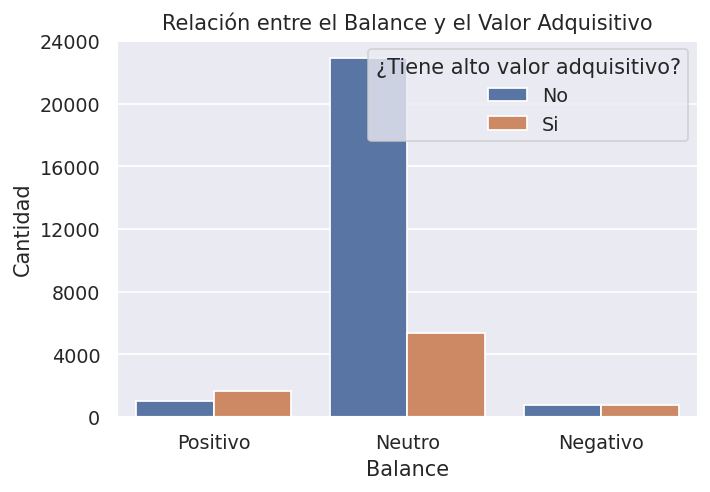

In [299]:
plt.figure(dpi=125)
ax = sns.countplot(x='balance',data=df,hue='tiene_alto_valor_adquisitivo')
ax.legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Si'], loc='upper right')
ax.set_xlabel("Balance")
ax.set_ylabel("Cantidad")
ax.set_title("Relación entre el Balance y el Valor Adquisitivo")
ax.set_yticks(range(0,25000,4000))
plt.show()

Del gráfico podemos observar que aquellos con balance neutro suelen no tener alto valor adquisitivo. En los demas casos, la division es equitativa, y por lo tanto no nos aporta demasiada información. Además, estas divisiones estan basadas en una cantidad de casos significativamente menor que el caso de balance neutro.

Analizaremos ahora aquellas personas con balance neutro:

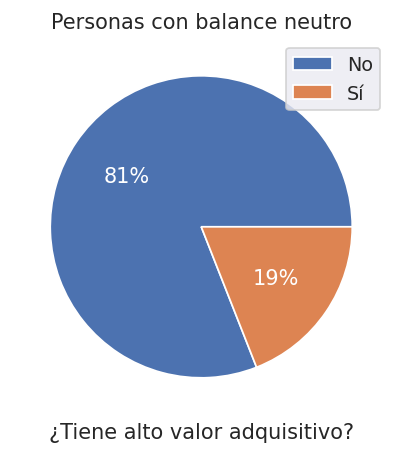

In [300]:
plt.figure(dpi=125)
df[(df['balance'] == 'Neutro')]['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},
)
plt.legend(labels=['No','Sí'])
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.ylabel('')
plt.title("Personas con balance neutro")
plt.show() 

Por lo que llegamos asi a nuestra segunda conclusión: 
  - **El 81% de las personas con balance neutro NO tienen alto valor adquisitivo**

 (No es tan fuerte como la anterior pero consideramos que es relevante)

## Años estudiados vs Valor Adquisitivo

Veamos cual es la proporción de personas con alto valor adquistivo con respecto a los años estudiados:

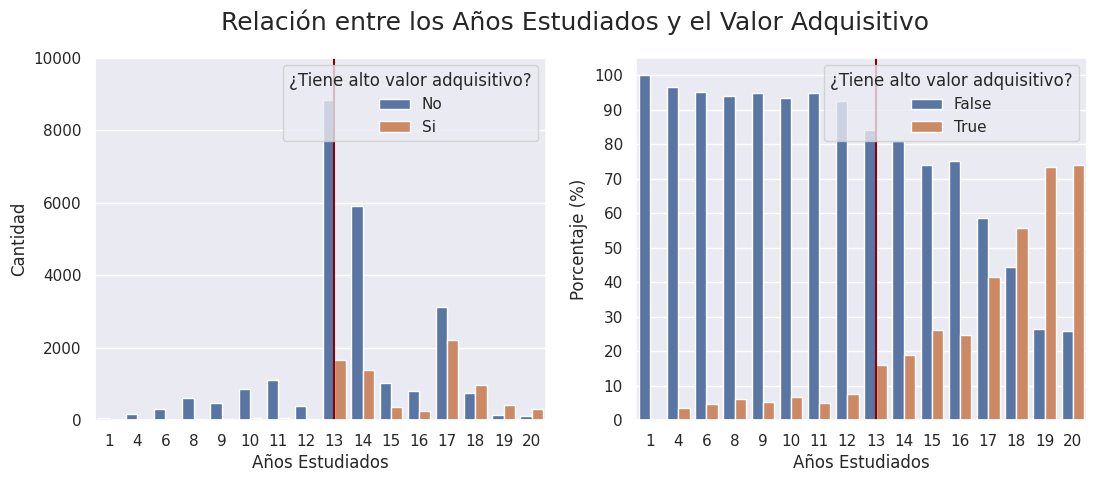

In [301]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8 * 1], dpi=100)
fig.suptitle('Relación entre los Años Estudiados y el Valor Adquisitivo', size=18)

axes[0] = sns.countplot(x='anios_estudiados',data=df,hue='tiene_alto_valor_adquisitivo', ax=axes[0])
axes[0].legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Si'], loc='upper right')
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Años Estudiados")
axes[0].set_yticks(range(0,11000,2000))
axes[0].axvline(x=8, color="darkred")

df_anios_porcentaje = df.groupby('anios_estudiados')['tiene_alto_valor_adquisitivo'].value_counts(normalize=True).mul(100).rename('porcentaje').reset_index()
axes[1] = sns.barplot(x='anios_estudiados', y='porcentaje', hue='tiene_alto_valor_adquisitivo', data=df_anios_porcentaje,ax=axes[1])
axes[1].legend(title='¿Tiene alto valor adquisitivo?', loc='upper right')
axes[1].set_ylabel("Porcentaje (%)")
axes[1].set_xlabel("Años Estudiados")
axes[1].set_yticks(range(0,110,10))
axes[1].axvline(x=8, color="darkred")

plt.show()

Del siguiente gráfico diferenciamos dos zonas esenciales. Por un lado aquellas que tienen menos de 13 años estudiados tienden a no tener alto valor adquisitivo. Esto último se ve claramente debido a que por cada cantidad de año estudiado las proporciones de no tener alto valor adquisitivo son mayores considerablemente. Si miramos el segundo gráfico notamos que con menos de 13 años estudiados, hay mas del 80% de personas que no tiene alto valor adquisitivo.

Por otro lado a medida que aumenta la cantidad de años estudiados tambien lo hace la proporción de personas con alto valor adquisitivo.

Veamos la cantidad de gente que tiene menos de 13 años estudiados:

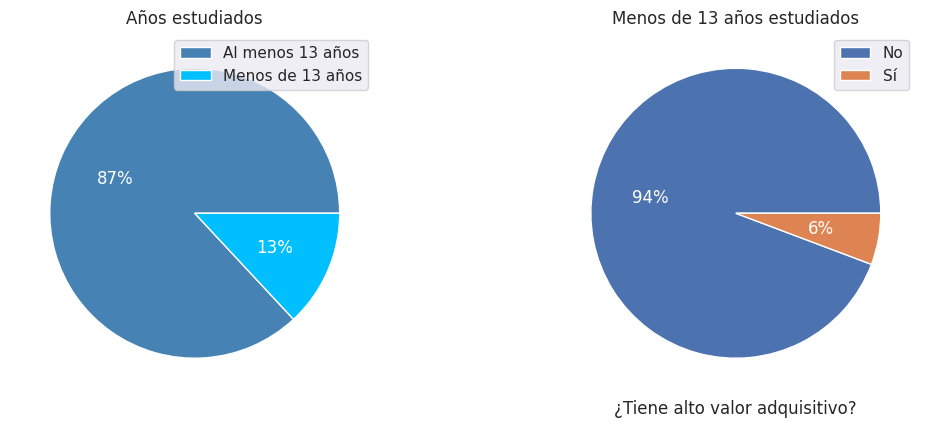

In [302]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)

(df['anios_estudiados'] <= 12).value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['steelblue', 'deepskyblue'], textprops={'color':"w"},ax=axes[0]
)
axes[0].set_title("Años estudiados")
axes[0].legend(labels=['Al menos 13 años','Menos de 13 años'])
axes[0].set_ylabel('')

df_menos_12 = df[df['anios_estudiados'] <= 12]
df_menos_12["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},ax=axes[1]
)
axes[1].legend(labels=['No','Sí'])
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_ylabel('')
axes[1].set_title("Menos de 13 años estudiados")

plt.show() 

A pesar de que las proporciones son muy favorables a decir que no tiene valor adquistivo (un 94%), hay que tener en cuenta que esta información es acerca del 13% del total de los datos. Por lo que la siguiente conclusión resulta ser debil con respecto a las anteriores:

- **El 94% de las personas que estudiaron menos de 13 años NO tienen alto valor adquisitivo.**

## Religión vs Valor Adquisitivo

Vemos si la religión nos aporta nueva información:

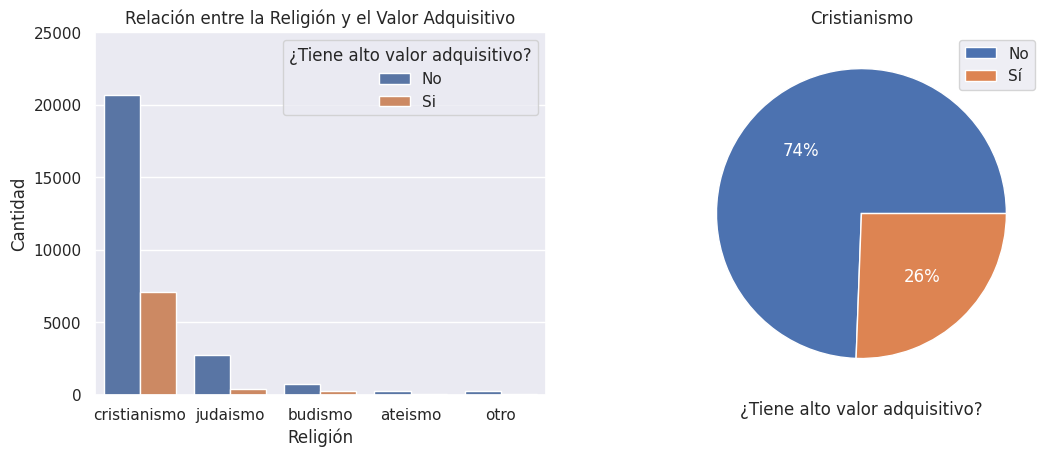

In [303]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)

sns.countplot(x='religion',hue='tiene_alto_valor_adquisitivo',data=df,ax=axes[0], order=['cristianismo', 'judaismo', 'budismo', 'ateismo', 'otro'])
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Religión")
axes[0].set_title("Relación entre la Religión y el Valor Adquisitivo")
axes[0].legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Si'], loc='upper right')
axes[0].set_yticks(range(0,26000,5000))

df_cristianismo = df[df['religion'] == 'cristianismo']
df_cristianismo["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%',ax=axes[1], textprops={'color':"w"},
)
axes[1].set_ylabel('')
axes[1].legend(labels=['No','Sí'])
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_title("Cristianismo")

plt.show()

Vemos que la categoría *cristianismo* que era la que tenía mayor cantidad de datos, tiene una distribución de valor adquisitivo similar a la distribución general, por lo que no nos aporta nueva información. 

*   **La religión no será relevante a la hora de estimar si una persona tiene o no alto valor adquisitivo.**

## Barrio vs Valor Adquisitivo

Considerando que la mayor parte de la gente entrevistada es del barrio *Palermo*, vemos la proporción de personas con alto valor adquisitivo en este barrio:

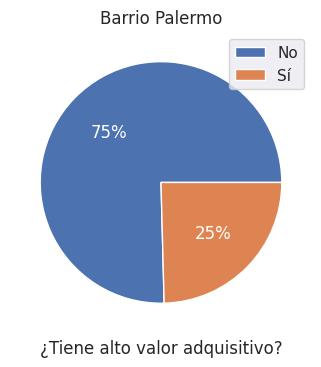

In [304]:
plt.figure(dpi=100)
df_palermo = df[df['barrio'] == "palermo"]
df_palermo['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"}
)
plt.legend(labels=['No','Sí'])
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.ylabel('')
plt.title("Barrio Palermo")
plt.show()

Esta información no nos aporta demasiado debido a que las proporciones son similares a la distribución general de la variable que queremos estimar.

Por lo que concluimos que:
*   **El barrio no será relevante a la hora de estimar si una persona tiene o no alto valor adquisitivo.**


## Estado Marital vs Valor Adquisitivo


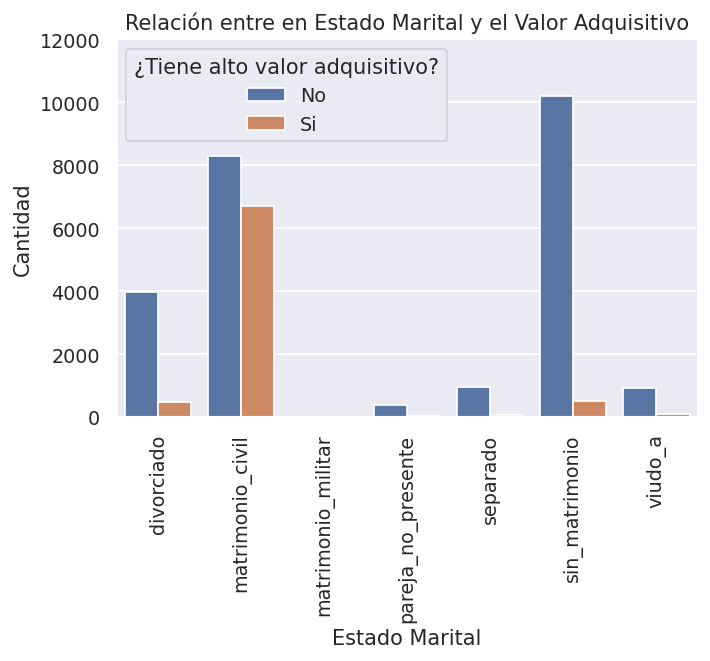

In [305]:
plt.figure(dpi=125)
ax = sns.countplot(x='estado_marital',data=df,hue='tiene_alto_valor_adquisitivo')
ax.legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Si'], loc='upper left')
ax.set_ylabel("Cantidad")
ax.set_xlabel("Estado Marital")
ax.set_yticks(range(0,13000,2000))
ax.set_title("Relación entre en Estado Marital y el Valor Adquisitivo")
plt.xticks(rotation=90)
plt.show()

Del siguiente gráfico vemos que si el estado marital de la persona entrevistada no es *matrimonio_civil*, la probabilidad de que no tenga alto valor adquisitivo son altas. Veamos cuanta gente cumple con esta condición:

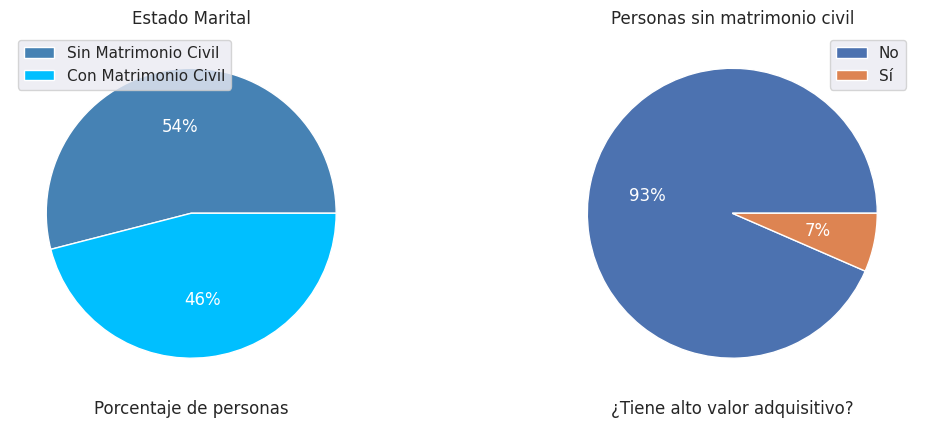

In [306]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)

(df['estado_marital'] != 'matrimonio_civil').value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['steelblue', 'deepskyblue'], textprops={'color':"w"},ax=axes[0]
)
axes[0].set_title("Estado Marital")
axes[0].legend(labels=['Sin Matrimonio Civil','Con Matrimonio Civil'], loc='upper left')
axes[0].set_xlabel('Porcentaje de personas')
axes[0].set_ylabel('')

df_no_matrimonio_civil = df[(df['estado_marital'] != "matrimonio_civil")]
df_no_matrimonio_civil['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},ax=axes[1]
)
axes[1].legend(labels=['No','Sí'], loc='upper right')
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_ylabel('')
axes[1].set_title("Personas sin matrimonio civil")

plt.show() 



Estos valores son muy relevantes debido a que la mitad de las personas cumplen esta condición y ademas tienen altas probabilidades de no tener alto valor adquisitivo.

Concluimos que: 
- **El 93% de las personas con estado marital distinto a *matrimonio_civil* no tienen alto valor adquisitivo.**
 
 (Esta conclusión resulta ser la mas fuerte hasta ahora y es la que usaremos inicialmente para predecir la variable objetivo)

## Edad vs Valor Adquisitivo

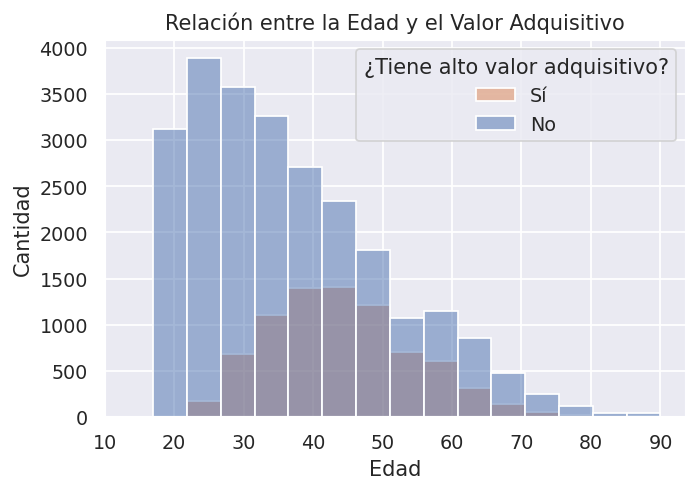

In [307]:
plt.figure(dpi=125)
ax = sns.histplot(x = 'edad', data=df, hue='tiene_alto_valor_adquisitivo', bins=15)
ax.set_title("Relación entre la Edad y el Valor Adquisitivo")
ax.set_ylabel("Cantidad")
ax.set_xlabel("Edad")
ax.set_yticks(range(0,4100,500))
ax.legend(title='¿Tiene alto valor adquisitivo?',labels=['Sí','No'], loc='upper right')
ax.set_xticks(range(10,100,10))

plt.show()

Vemos que las mayores diferencias entre la cantidad de personas con y sin alto valor adquisitivo se da en las personas menores a 30 años.
Analizamos estos casos en particular:

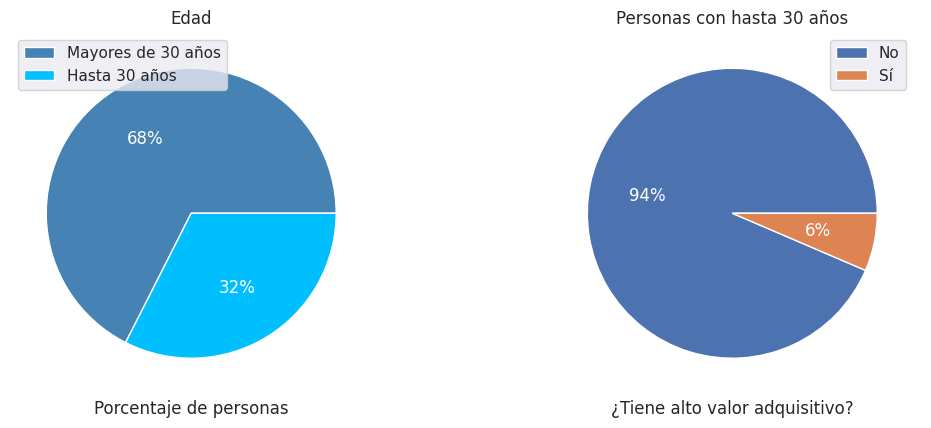

In [308]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)

(df['edad'] <= 30).value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['steelblue', 'deepskyblue'], textprops={'color':"w"},ax=axes[0]
)
axes[0].set_title("Edad")
axes[0].legend(labels=['Mayores de 30 años','Hasta 30 años'], loc='upper left')
axes[0].set_xlabel('Porcentaje de personas')
axes[0].set_ylabel('')

df_menor_30 = df[(df['edad'] <= 30)]
df_menor_30 ['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},ax=axes[1]
)
axes[1].legend(labels=['No','Sí'], loc='upper right')
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_ylabel('')
axes[1].set_title("Personas con hasta 30 años")

plt.show() 

Vemos que el 94% de las personas con menos de 30 años no tienen alto valor adquisitivo. Tambien vemos que este grupo representa el 32% de la cantidad total de datos, por lo que es una relación fuerte como la relación obtenida en el género, aunque no tanto como la del estado marital.

Por lo que concluimos que:
*   **Las personas con menos de 30 años tienden a no tener alto valor adquisitivo.**

## Horas de trabajo vs Valor Adquisitivo

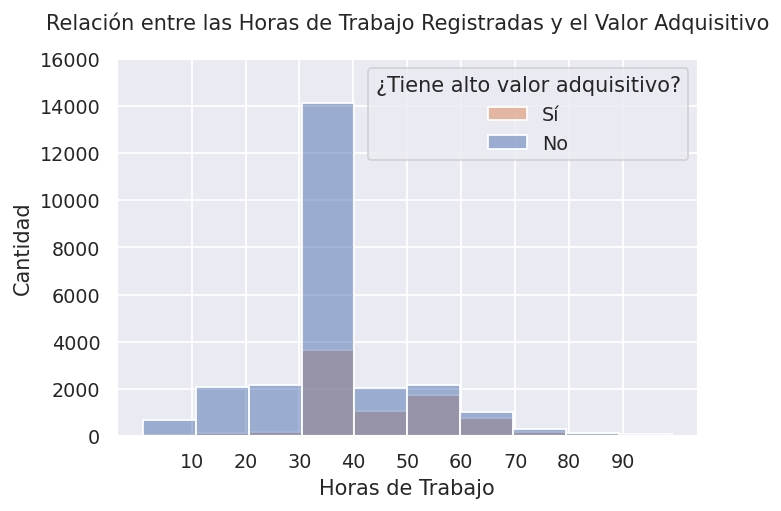

In [309]:
plt.figure(dpi=125)
ax = sns.histplot(x = 'horas_trabajo_registradas', data=df, hue='tiene_alto_valor_adquisitivo', bins=10)
ax.set_title("Relación entre las Horas de Trabajo Registradas y el Valor Adquisitivo", y=1.05)
ax.set_ylabel("Cantidad")
ax.set_xlabel("Horas de Trabajo")
ax.set_yticks(range(0,16100,2000))
ax.legend(title='¿Tiene alto valor adquisitivo?',labels=['Sí','No'], loc='upper right')
ax.set_xticks(range(10,100,10))

plt.show()

Vemos que las mayores diferencias entre la cantidad de personas con y sin alto valor adquisitivo se da en las personas con hasta 30 horas de trabajo semanales.
Analizamos estos casos en particular:

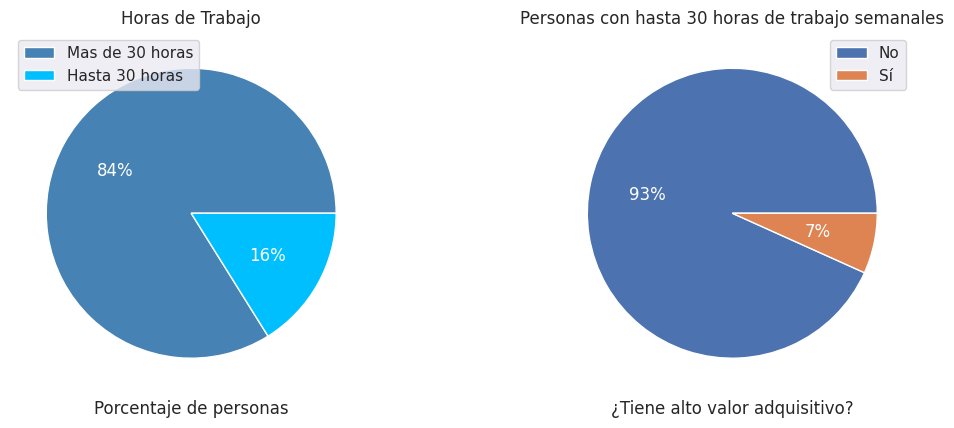

In [310]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)

(df['horas_trabajo_registradas'] <= 30).value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['steelblue', 'deepskyblue'], textprops={'color':"w"},ax=axes[0]
)
axes[0].set_title("Horas de Trabajo")
axes[0].legend(labels=['Mas de 30 horas','Hasta 30 horas'], loc='upper left')
axes[0].set_xlabel('Porcentaje de personas')
axes[0].set_ylabel('')

df_menos_30 = df[(df['horas_trabajo_registradas'] <= 30)]
df_menos_30 ['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},ax=axes[1]
)
axes[1].legend(labels=['No','Sí'], loc='upper right')
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_ylabel('')
axes[1].set_title("Personas con hasta 30 horas de trabajo semanales")

plt.show() 

Vemos que solo el 16% de las personas trabajan hasta 30 horas por semana. De este grupo, el 93% no tiene alto valor adquisitivo. A comparación de las conclusiones obtenidas anteriormente, esta resulta ser debil.

Por lo que concluimos que:
*   **Las personas con menos de 30 horas de trabajo registradas tienden a no tener alto valor adquisitivo.**

## Trabajo vs Valor Adquisitivo

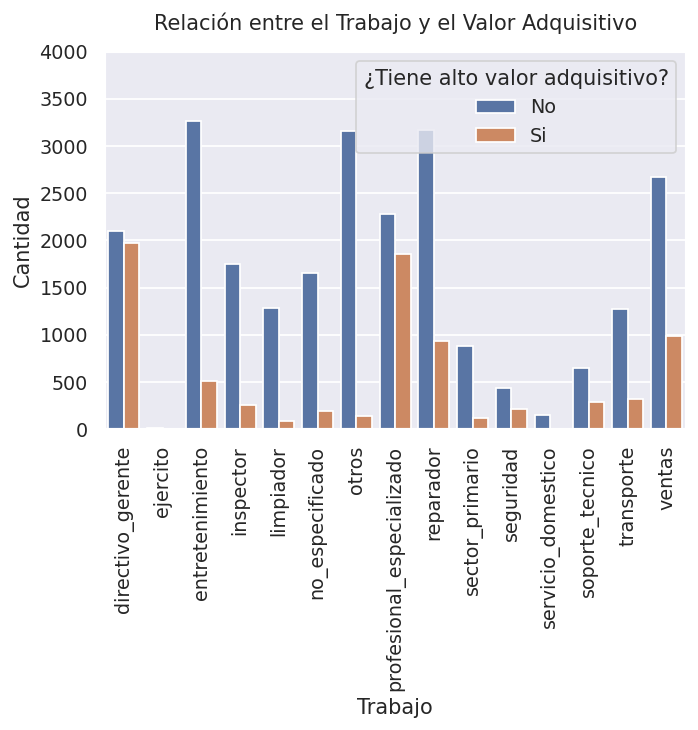

In [311]:
plt.figure(dpi=125)
ax = sns.countplot(data=df, x='trabajo', hue='tiene_alto_valor_adquisitivo')
plt.legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Si'], loc='upper right')
ax.set_ylabel("Cantidad")
ax.set_xlabel("Trabajo")
ax.set_title("Relación entre el Trabajo y el Valor Adquisitivo", y=1.03)
ax.set_yticks(range(0,4500,500))
plt.xticks(rotation=90)
plt.show()

Vemos que varian mucho las proporsiones de la variable objetivo en cada categoría. Por otra parte, vemos que no hay un criterio a simple vista que nos permita agrupar ciertos trabajos. Ademas, trabajar con una categoría específica podría ocasionar problemas de overfitting.

Cabe destacar que las categorias con mayor cantidad de datos tienen hasta un 15% de los datos, como vimos en el gráfico de distribución inicial, por lo que cualquier conclusión obtenida a partir de una categoría particular no sería demasiado fuerte.


Por lo que concluimos que:
*   **El trabajo no será relevante a la hora de predecir si una persona tiene o no alto valor adquisitivo**

## Categoria de Trabajo vs Valor Adquisitivo

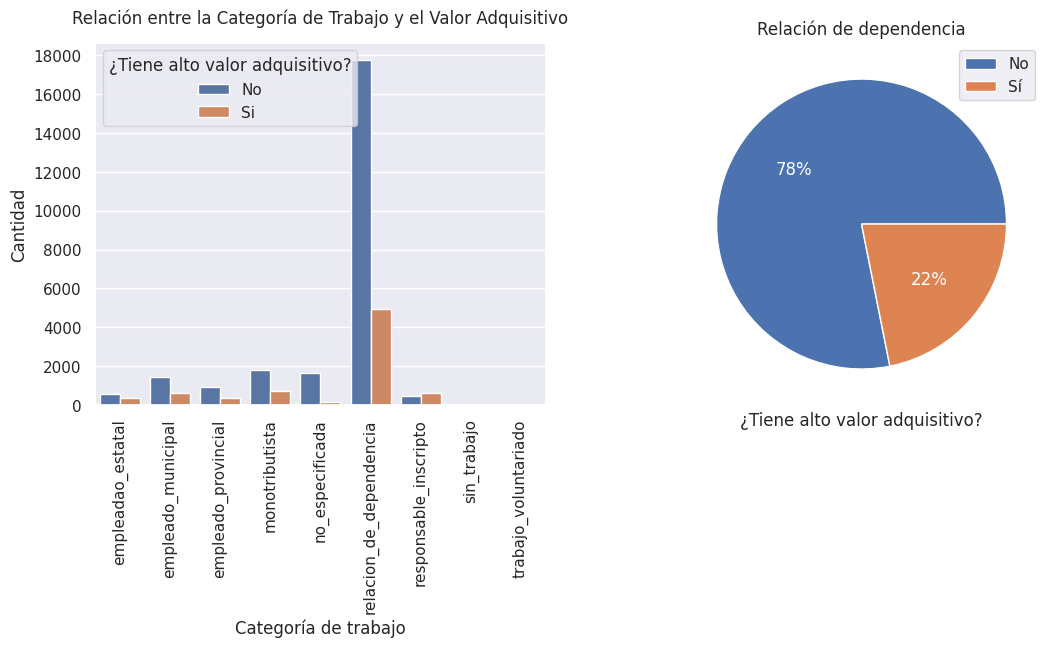

In [312]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)

sns.countplot(data=df, x='categoria_de_trabajo', hue='tiene_alto_valor_adquisitivo',ax=axes[0])
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Categoría de trabajo")
axes[0].legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Si'], loc='upper left')
axes[0].set_yticks(range(0,19000,2000))
axes[0].set_title("Relación entre la Categoría de Trabajo y el Valor Adquisitivo", y=1.03)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

df_rd = df[df['categoria_de_trabajo'] == 'relacion_de_dependencia']
df_rd["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%',ax=axes[1], textprops={'color':"w"},
)
axes[1].set_ylabel('')
axes[1].legend(labels=['No','Sí'])
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_title("Relación de dependencia")

plt.show()

Para el caso de *categoria_de_trabajo* vemos que nos ocurre algo similar a *religión*, existe una categoria la cual cuenta con la mayor parte de los casos (*Relacion de dependencia*) y la proporción de la variable objetivo sobre la misma no proporciona nueva información.

Por lo que concluimos que:
*   **La categoría de trabajo no será relevante a la hora de predecir si una persona tiene o no alto valor adquisitivo**

## Rol familiar vs Valor Adquisitivo

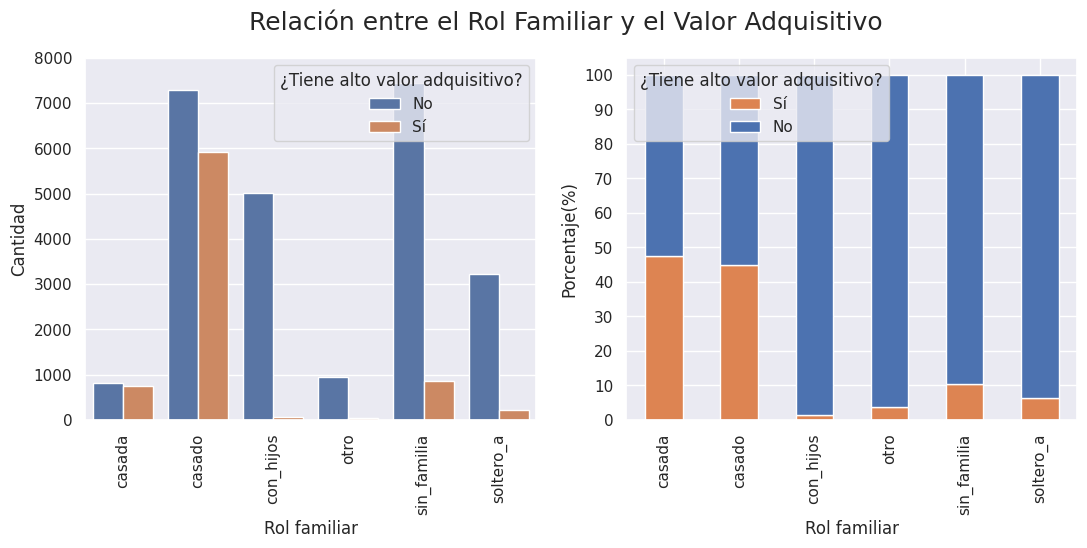

In [313]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)
fig.suptitle('Relación entre el Rol Familiar y el Valor Adquisitivo', y=0.98, size=18)

sns.countplot(data=df, x='rol_familiar_registrado', hue='tiene_alto_valor_adquisitivo',ax=axes[0])
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Rol familiar")
axes[0].legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Sí'], loc='upper right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_yticks(range(0,8100,1000))

new_df = df[['rol_familiar_registrado','tiene_alto_valor_adquisitivo']]
new_df = new_df.groupby('rol_familiar_registrado').agg(['sum','count']).reset_index()
new_df['si'] = (new_df['tiene_alto_valor_adquisitivo']['sum'] * 100/new_df['tiene_alto_valor_adquisitivo']['count'])
new_df['no'] = 100 - new_df['si']
new_df = new_df._drop_axis('tiene_alto_valor_adquisitivo',axis='columns', level = 0)
new_df.set_index('rol_familiar_registrado',drop=True,inplace=True)  

new_df.plot(kind="bar", stacked=True,color=['C1','C0'],ax=axes[1])
axes[1].set_ylabel("Porcentaje(%)")
axes[1].set_xlabel("Rol familiar")
axes[1].legend(title='¿Tiene alto valor adquisitivo?',labels=['Sí','No'], loc='upper left')
axes[1].set_yticks(range(0,110,10))

plt.show()

A partir de los gráficos vemos que si la persona no esta *casada/casado*, es muy probable que no tenga alto valor adquisitivo. Vemos cuantas personas no estan casadas: 

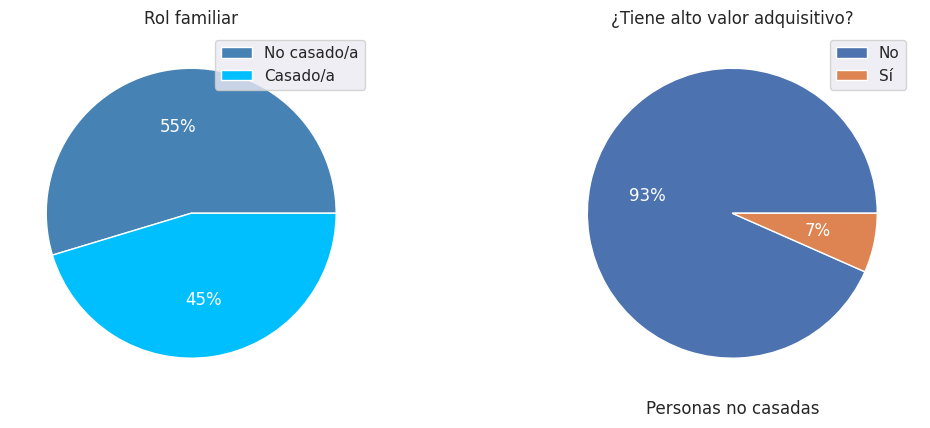

In [314]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)

((df['rol_familiar_registrado'] != 'casado') & (df['rol_familiar_registrado'] != 'casada') ).value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['steelblue', 'deepskyblue'], textprops={'color':"w"},ax=axes[0]
)
axes[0].set_title("Rol familiar")
axes[0].legend(labels=['No casado/a','Casado/a'])
axes[0].set_ylabel('')

df_no_casadas = df[(df['rol_familiar_registrado'] != "casado") & (df['rol_familiar_registrado'] != "casada")]
df_no_casadas['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},ax=axes[1]
)
axes[1].legend(labels=['No','Sí'])
axes[1].set_xlabel("Personas no casadas")
axes[1].set_ylabel('')
axes[1].set_title("¿Tiene alto valor adquisitivo?")

plt.show() 

Nuevamente, estos valores son muy relevantes, similar al caso del estado marital.

Por lo que concluimos que:
*   **El rol familiar es tan relevante como el estado familiar para predecir la variable target**

# Relaciones

Una vez analizado las distintas columnas con nuestra variable objetivo (ver si una persona tiene o no alto valor adquisitivo) llegamos a las distintas conclusiones que se muestran a continuación:

*   El estado marital de la persona es muy relevante en el valor adquisitivo. Si el mismo no es *matrimonio_civil*, tiende a no tener alto valor adquisitivo
*   El rol familiar registrado tambien es muy relevante en cuanto al valor adquisitivo
*   Si la persona es mujer, tiende a no tener alto valor adquisitivo
*   Si la persona tiene balance neutro, tiende a no tener alto valor adquisitivo
*   Si la persona tiene un balance positivo y alto, tiende a tener alto valor adquisitivo
*   Si la persona estudió menos de 13 años, tiende a no tener alto valor adquisitivo
*   Si la persona trabaja menos de 30 horas por semana, tiende a no tener alto valor adquisitivo
*   Si la persona tiene menos de 30 años, tiende a no tener alto valor adquisitivo
*   La religión no nos aportan información relevante
*   Tanto el trabajo como la categoria de trabajo no nos aportan información relevante
*   Por último, el barrio tampoco nos dice si la persona tiene o no alto valor adquisitivo

Procederemos a elegir la que consideramos que divida más a la muestra. En nuestro caso decidimos que el **estado marital** de la persona divide considerablemente si no es **matrimonio_civil**.

Inicialmente sabemos que si el estado marital de la persona es *matrimonio_civil* podemos decir que no tendrá alto valor adquisitivo, pero ¿que pasa en el otro caso?. Comenzaremos estudiando este caso

In [315]:
df_mc = df[df['estado_marital'] == "matrimonio_civil"]

Veamos cuantos son los que tienen alto valor adquisitivo:

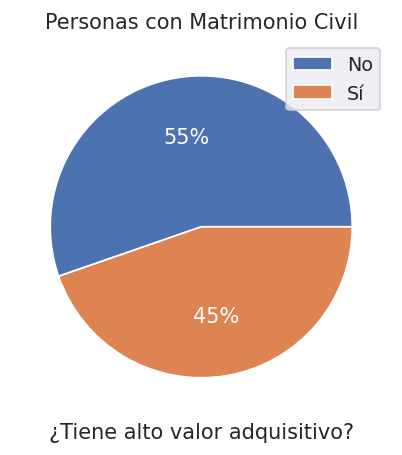

In [316]:
plt.figure(dpi=125)
df_mc['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"}
)
plt.legend(labels=['No','Sí'])
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.ylabel('')
plt.title("Personas con Matrimonio Civil")
plt.show()

La división resulta igualitaria para ambas partes, por lo que intentaremos buscar alguna otra columna que separe considerablemente para poder llegar a una nueva conclusión.


**NOTA:** Si bien analizamos todas las posibles combinaciónes de columnas con *Matrimonio Civil*, decidimos exponer en este trabajo aquellas que consideramos que nos aportaban informacion relevante.

## Matrimonio Civil y Balance

Veamos si existe alguna relación entre el matrimonio civil y el balance de la persona (recordemos que el balance puede ser: Negativo, Neutro o Positivo):

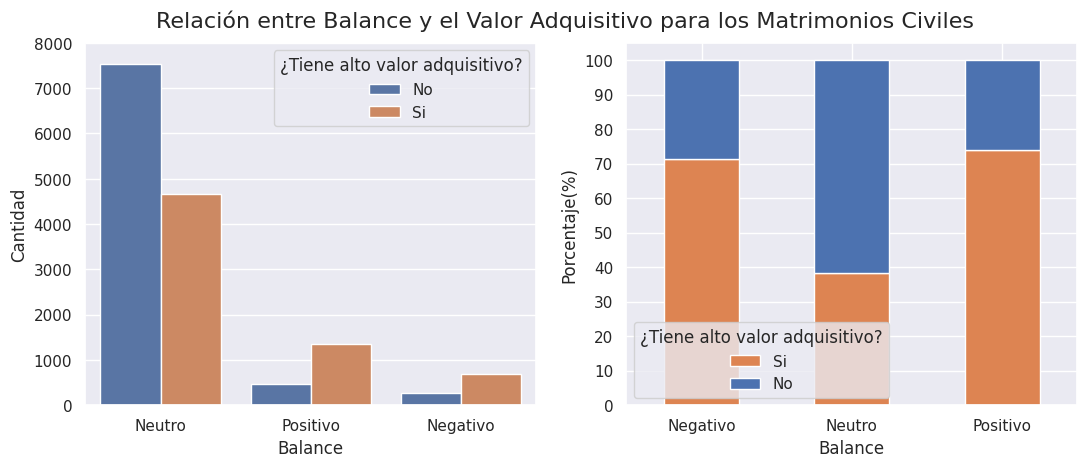

In [317]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)
fig.suptitle('Relación entre Balance y el Valor Adquisitivo para los Matrimonios Civiles', y=0.95, size=16)

sns.countplot(x='balance',data=df_mc,hue='tiene_alto_valor_adquisitivo',ax=axes[0])
axes[0].legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Si'], loc='upper right')
axes[0].set_xlabel("Balance")
axes[0].set_ylabel("Cantidad")
axes[0].set_yticks(range(0,8100,1000))

new_df = df_mc[['balance','tiene_alto_valor_adquisitivo']]
new_df = new_df.groupby('balance').agg(['sum','count']).reset_index()
new_df['si'] = (new_df['tiene_alto_valor_adquisitivo']['sum'] * 100/new_df['tiene_alto_valor_adquisitivo']['count'])
new_df['no'] = 100 - new_df['si']
new_df = new_df._drop_axis('tiene_alto_valor_adquisitivo',axis='columns', level=0)
new_df.set_index('balance',drop=True,inplace=True)  


new_df.plot(kind="bar", stacked=True,color=['C1','C0'],ax=axes[1])
axes[1].set_ylabel("Porcentaje(%)")
axes[1].set_xlabel("Balance")
axes[1].legend(title='¿Tiene alto valor adquisitivo?',labels=['Si','No'], loc='lower left')
axes[1].set_yticks(range(0,110,10))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.show()

Vemos del primer gráfico que la mayor parte de los casos tiene un balance *Neutro*. Por otra parte, vemos que en el segundo gráfico la proporción de la variable objetivo para los casos con balance *Positivo* y *Negativo* favorece a decir que la persona tiene alto valor adquisitivo. Analizamos primero aquellas personas con balance *Negativo*:



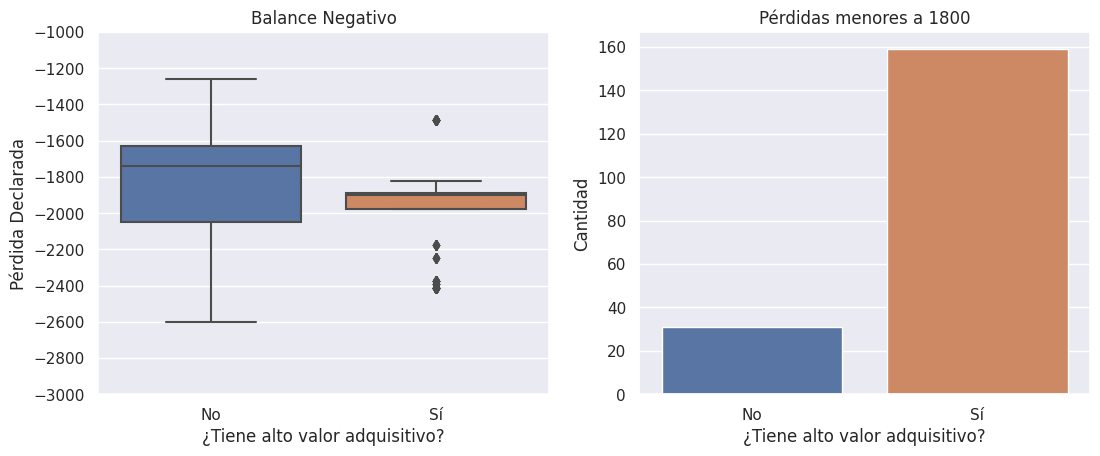

In [318]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_aux = df_mc[(df_mc["ganancia_perdida_declarada_bolsa_argentina"] < 0)]
sns.boxplot(
    data=df_aux,
    y='ganancia_perdida_declarada_bolsa_argentina',
    x='tiene_alto_valor_adquisitivo',
    palette=['C0', "C11"],
    ax=axes[0]
)

axes[0].set_title("Balance Negativo")
axes[0].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[0].set_ylabel("Pérdida Declarada")
axes[0].set_xticklabels(['No', 'Sí'], rotation=0)
axes[0].set_yticks(range(-1000,-3100,-200))
axes[0].set_ylim([-3000,-1000])

df_aux2 = df_mc[(df_mc['ganancia_perdida_declarada_bolsa_argentina'] > -1800) & (df_mc['ganancia_perdida_declarada_bolsa_argentina'] < 0)]
sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_aux2,ax=axes[1], order=[True, False])
axes[1].set_title("Pérdidas menores a 1800")
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_ylabel("Cantidad")
axes[1].set_yticks(range(0,161,20))
axes[1].set_xticklabels(['No', 'Sí'], rotation=0)

plt.show()

Del primer gráfico vemos que de las personas que con alto valor adquisitivo tienen balance negativo, sus perdidas declaradas son mayores a 1800. En el segundo gráfico analizamos las personas con perdidas menores a dicho valor.
Si bien las proporciones son muy favorales a decir que estas personas tienen alto valor adquisitivo, esta conclusión sería muy débil debido a la baja cantidad de datos. 

Analizamos ahora aquellas personas con balance *Positivo*:

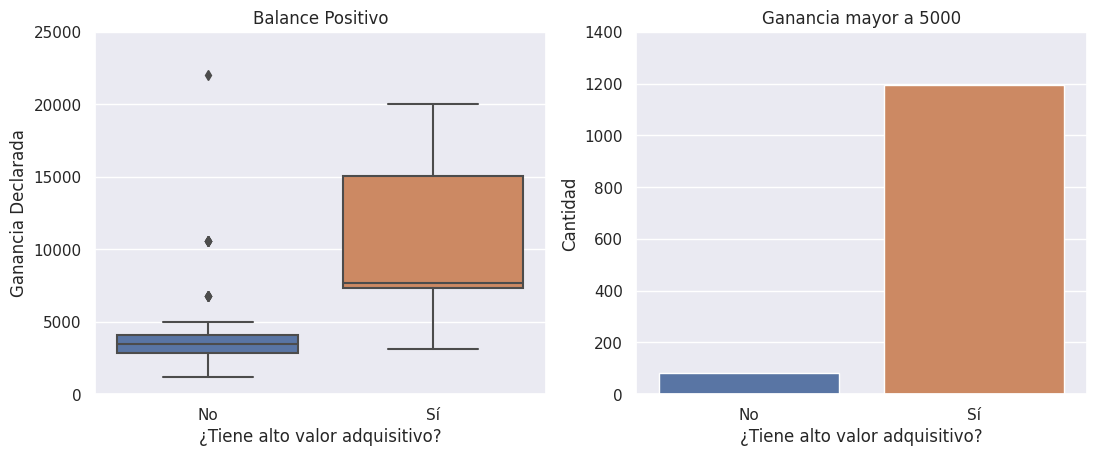

In [319]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_aux = df_mc[(df_mc["ganancia_perdida_declarada_bolsa_argentina"] > 0) & (df_mc["ganancia_perdida_declarada_bolsa_argentina"] < 40000)]
sns.boxplot(
    data=df_aux,
    y='ganancia_perdida_declarada_bolsa_argentina',
    x='tiene_alto_valor_adquisitivo',
    palette=['C0', "C11"],
    ax=axes[0]
)
axes[0].set_title("Balance Positivo")
axes[0].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[0].set_ylabel("Ganancia Declarada")
axes[0].set_xticklabels(['No', 'Sí'], rotation=0)
axes[0].set_yticks(range(0,26000,5000))


df_aux2 = df_mc[df_mc['ganancia_perdida_declarada_bolsa_argentina'] > 5000]
sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_aux2,ax=axes[1])
axes[1].set_title("Ganancia mayor a 5000")
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_ylabel("Cantidad")
axes[1].set_yticks(range(0,1500,200))
axes[1].set_xticklabels(['No', 'Sí'], rotation=0)

plt.show()

Vemos en el primer gráfico que las ganancias de las personas con alto valor adquisitivo tienden a ser mucho mayores que las de las personas sin alto valor adquisitivo. En el segundo grafico analizamos los casos con ganancia mayor a 5000, valor en el cual según el gráfico es poco probable encontrar a alguien sin alto valor adquisitivo. 

Concluimos que las personas que no estan casadas y tienen ganancias mayores a 5000, tienden a tener alto valor adquisitivo. A su vez esta relación es extraida a partir de una cantidad muy reducida de datos.

## Matrimonio civil y Años estudiados



Veamos como se relacionan con los años estudiados:

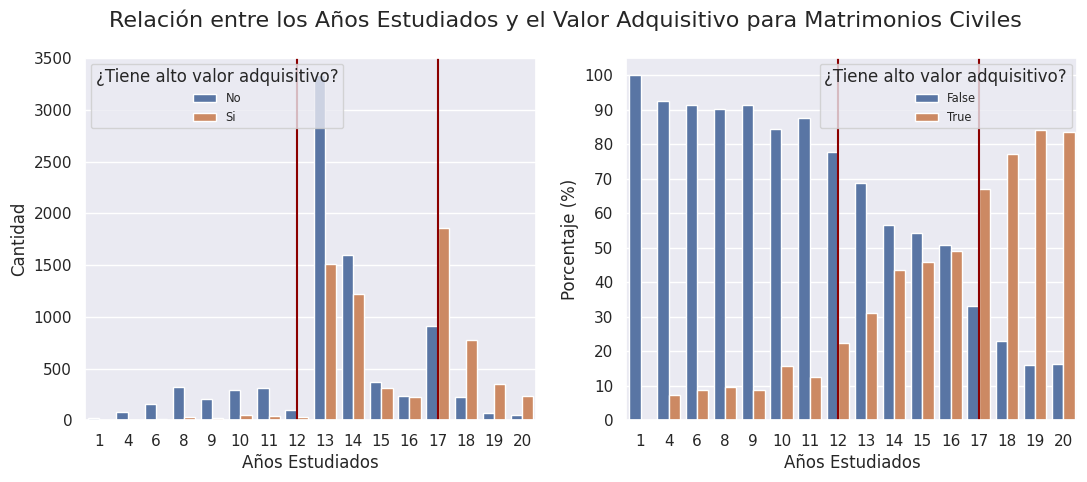

In [320]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8 * 1], dpi=100)
fig.suptitle('Relación entre los Años Estudiados y el Valor Adquisitivo para Matrimonios Civiles', y=0.98, size=16)

sns.countplot(x='anios_estudiados',data=df_mc,hue='tiene_alto_valor_adquisitivo',ax=axes[0])
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Años Estudiados")
axes[0].legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Si'], loc='upper left', fontsize='x-small')
axes[0].axvline(x=7, color="darkred")
axes[0].axvline(x=12, color="darkred")

df_anios_porcentaje = df_mc.groupby('anios_estudiados')['tiene_alto_valor_adquisitivo'].value_counts(normalize=True).mul(100).rename('porcentaje').reset_index()
axes[1] = sns.barplot(x='anios_estudiados', y='porcentaje', hue='tiene_alto_valor_adquisitivo', data=df_anios_porcentaje,ax=axes[1])
axes[1].legend(title='¿Tiene alto valor adquisitivo?', loc='upper right', fontsize='x-small')
axes[1].set_ylabel("Porcentaje (%)")
axes[1].set_xlabel("Años Estudiados")
axes[1].set_yticks(range(0,110,10))
axes[1].axvline(x=7, color="darkred")
axes[1].axvline(x=12, color="darkred")

plt.show()

Observamos que es similar a la distribución de los años estudiados general. Nuevamente tenemos dos zonas esenciales:

-   Aquellos con al menos 17 años estudiados tienden a tener alto valor adquisitivo
-   Aquellos con menos de 13 años estudiados tienden a no tener alto valor adquisitivo

Veamos para cada zona cuanto divide a la muestra y si es considerable para llegar a una conclusión:



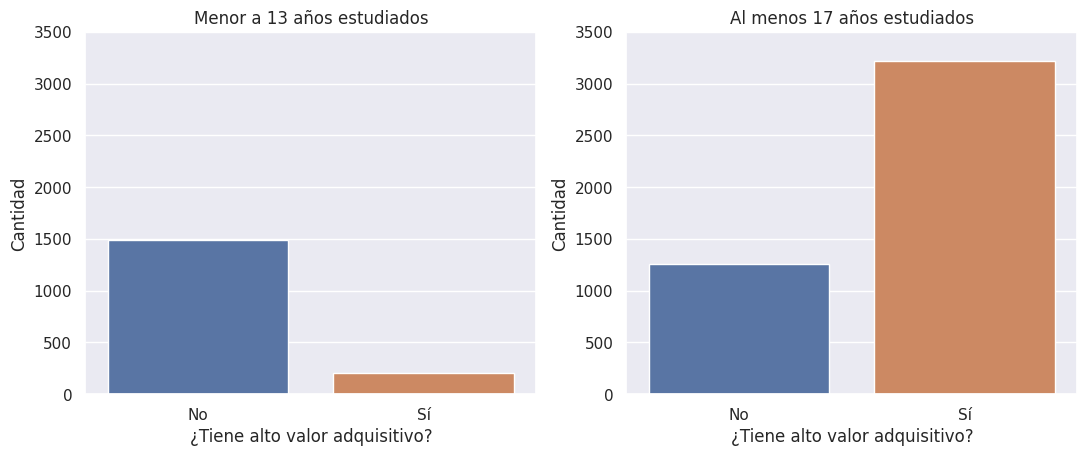

In [321]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_mc_sec = df_mc[df_mc['anios_estudiados'] <= 12]
df_mc_uni = df_mc[df_mc['anios_estudiados'] > 16]

ax0 = sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_mc_sec,ax=axes[0])
ax0.set_title("Menor a 13 años estudiados")
ax0.set_ylabel("Cantidad")
ax0.set_xlabel("¿Tiene alto valor adquisitivo?")
ax0.set_xticklabels(['No', 'Sí'], rotation=0)
ax0.set_yticks(range(0,3600,500))

ax1 = sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_mc_uni,ax=axes[1])
ax1.set_title("Al menos 17 años estudiados")
ax1.set_ylabel("Cantidad")
ax1.set_xticklabels(['No', 'Sí'], rotation=0)
ax1.set_yticks(range(0,3600,500))
ax1.set_xlabel("¿Tiene alto valor adquisitivo?")


plt.show()

Vemos que para aquellos con menos de 13 años estudiados las proporciones se diferencian significativamente, pero la cantidad de casos es mayor para aquellos con al menos 17 años estudiados. Entonces debemos tomar una decisión en cual elegir y que consideremos que será relevante para la predicción de la variable objetivo. Optamos por quedarnos con:

*    Aquellos con mas de 16 años estudiados tienden a tener alto valor adquisitivo

(Esta conclusión resulta ser mas fuerte que la del balance puesto que hay mas casos)

Ahora debemos observar el otro caso, las personas que estan casadas civilmente pero no tienen mas de 16 años estudiados, y ver como podemos subdividirlas.

### Menos de 16 años estudiados

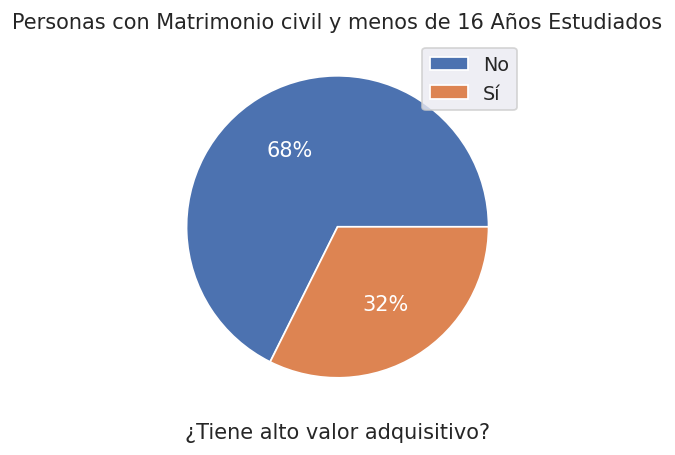

In [322]:
plt.figure(dpi=125)

df_mc_16 = df_mc[df_mc['anios_estudiados'] < 16]
df_mc_16['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"}
)
plt.legend(labels=['No','Sí'])
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.ylabel('')
plt.title("Personas con Matrimonio civil y menos de 16 Años Estudiados")
plt.show()

Como la mayoria de las personas que nos queda no tienen alto valor adquisitivo (esta será nuestra estimación final), debemos buscar alguna división fuerte que estime que la persona tendrá alto valor adquisitivo.

Provemos nuevamente con el balance:

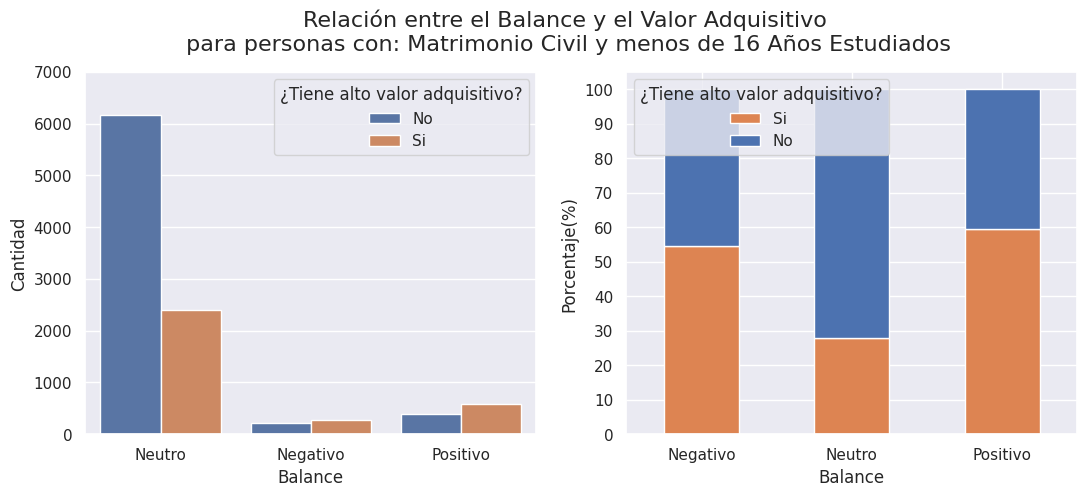

In [323]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8* 1], dpi=100)
fig.suptitle('Relación entre el Balance y el Valor Adquisitivo\n para personas con: Matrimonio Civil y menos de 16 Años Estudiados', y=1.01, size=16)

sns.countplot(x='balance',data=df_mc_16,hue='tiene_alto_valor_adquisitivo',ax=axes[0])
axes[0].legend(title='¿Tiene alto valor adquisitivo?',labels=['No','Si'], loc='upper right')
axes[0].set_xlabel("Balance")
axes[0].set_ylabel("Cantidad")
axes[0].set_yticks(range(0,7500,1000))

new_df = df_mc_16[['balance','tiene_alto_valor_adquisitivo']]
new_df = new_df.groupby('balance').agg(['sum','count']).reset_index()
new_df['si'] = (new_df['tiene_alto_valor_adquisitivo']['sum'] * 100/new_df['tiene_alto_valor_adquisitivo']['count'])
new_df['no'] = 100 - new_df['si']
new_df = new_df._drop_axis('tiene_alto_valor_adquisitivo',axis='columns', level = 0)
new_df.set_index('balance',drop=True,inplace=True)  


new_df.plot(kind="bar", stacked=True,color=['C1','C0'],ax=axes[1])
axes[1].set_ylabel("Porcentaje(%)")
axes[1].set_xlabel("Balance")
axes[1].legend(title='¿Tiene alto valor adquisitivo?',labels=['Si','No'], loc='upper left')
axes[1].set_yticks(range(0,110,10))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.show()

Nuevamente analizaremos aquellos casos con balance *Positivo* y *Negativo* como lo hemos hecho anteriormente.

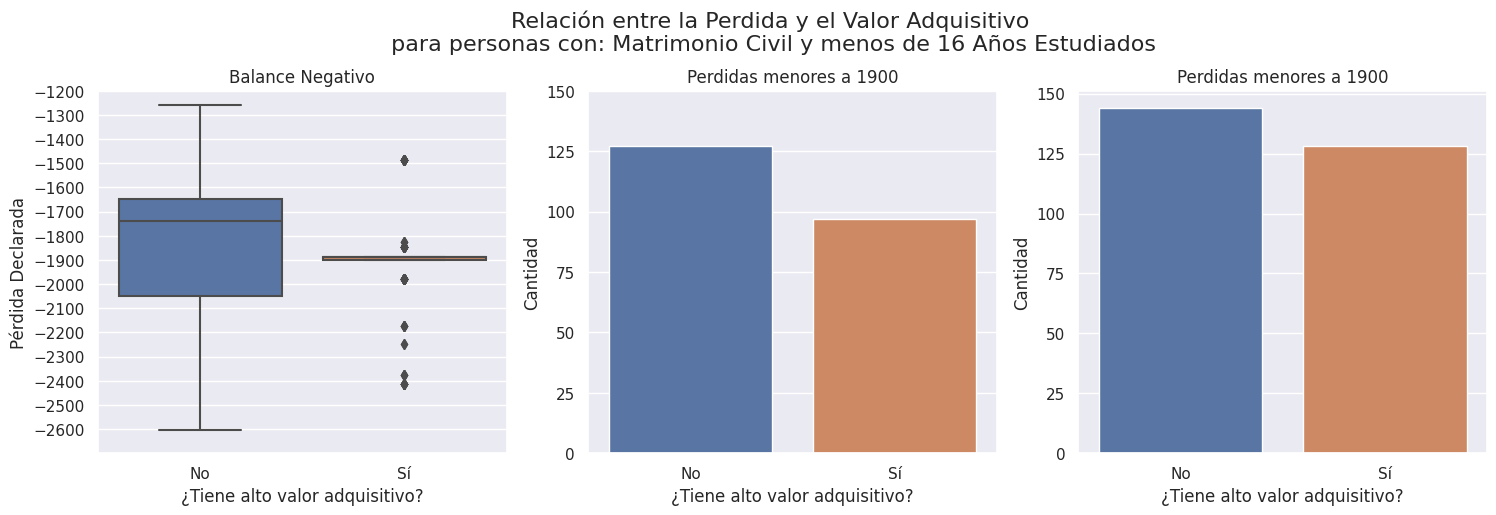

In [324]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[6.4 * 2.8, 4.8], dpi=100)
fig.suptitle('Relación entre la Perdida y el Valor Adquisitivo\n para personas con: Matrimonio Civil y menos de 16 Años Estudiados', y=1.05, size=16)

df_aux = df_mc_16[(df_mc_16["ganancia_perdida_declarada_bolsa_argentina"] < 0)]
sns.boxplot(
    data=df_aux,
    y='ganancia_perdida_declarada_bolsa_argentina',
    x='tiene_alto_valor_adquisitivo',
    palette=['C0', "C11"],
    ax=axes[0]
)
axes[0].set_title("Balance Negativo")
axes[0].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[0].set_ylabel("Pérdida Declarada")
axes[0].set_xticklabels(['No', 'Sí'], rotation=0)
axes[0].set_yticks(range(-1200,-2700,-100))
axes[0].set_ylim([-2700,-1200])

df_aux2 = df_mc_16[(df_mc_16['ganancia_perdida_declarada_bolsa_argentina'] < -1900)]
sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_aux2,ax=axes[1], order=[True, False])
axes[1].set_title("Perdidas menores a 1900")
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_ylabel("Cantidad")
axes[1].set_yticks(range(0,151,25))
axes[1].set_xticklabels(['No', 'Sí'], rotation=0)

df_aux3 = df_mc_16[(df_mc_16['ganancia_perdida_declarada_bolsa_argentina'] < 0)  & (df_mc_16['ganancia_perdida_declarada_bolsa_argentina'] > -1900)]
sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_aux3,ax=axes[2], order=[True, False])
axes[2].set_title("Perdidas menores a 1900")
axes[2].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[2].set_ylabel("Cantidad")
axes[2].set_yticks(range(0,151,25))
axes[2].set_xticklabels(['No', 'Sí'], rotation=0)

plt.show()

En el primer gráfico observamos que las personas con perdidas y alto valor adquisitivo estan concentradas en el valor -1900.
En los siguientes gráficos analizamos los casos de perdidas mayores a 1900 y menors a 1900 y observamos en ambos que las proporsiones de la variable objetivo son similares, y además están basadas en una cantidad de datos muy pequeña, por lo que no es una conclusión fuerte.

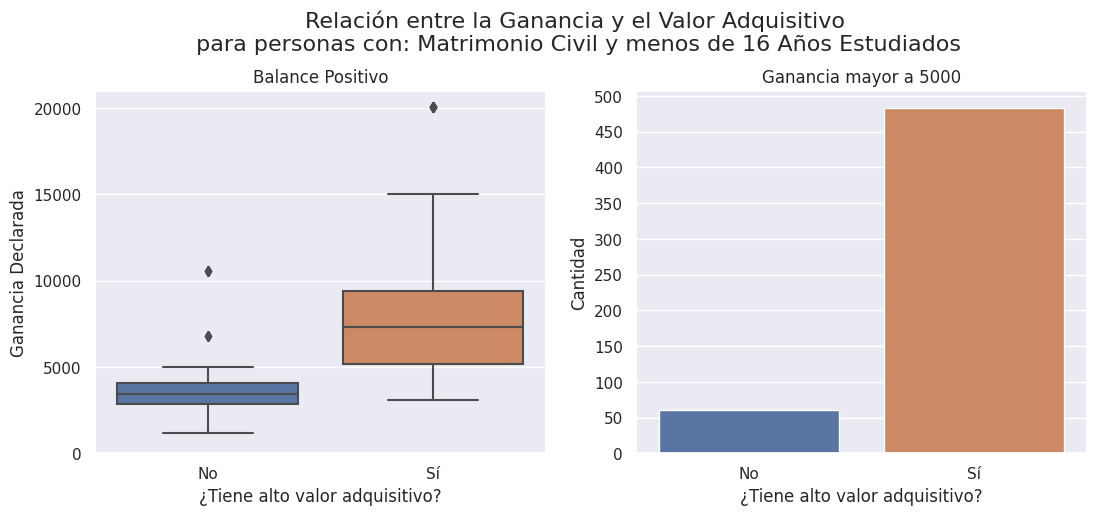

In [325]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)
fig.suptitle('Relación entre la Ganancia y el Valor Adquisitivo\n para personas con: Matrimonio Civil y menos de 16 Años Estudiados', y=1.05, size=16)

df_aux = df_mc_16[(df_mc_16["ganancia_perdida_declarada_bolsa_argentina"] > 0)]
axes[0] = sns.boxplot(
    data=df_aux,
    y='ganancia_perdida_declarada_bolsa_argentina',
    x='tiene_alto_valor_adquisitivo',
    palette=['C0', "C11"],
    ax=axes[0]
)
axes[0].set_ylim([0,21000])
axes[0].set_yticks(range(0,21000,5000))
axes[0].set_title("Balance Positivo")
axes[0].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[0].set_ylabel("Ganancia Declarada")
axes[0].set_xticklabels(['No', 'Sí'], rotation=0)

df_aux2 = df_mc_16[df_mc_16['ganancia_perdida_declarada_bolsa_argentina'] > 5000]
sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_aux2,ax=axes[1])
axes[1].set_title("Ganancia mayor a 5000")
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_ylabel("Cantidad")
axes[1].set_yticks(range(0,510,50))
axes[1].set_xticklabels(['No', 'Sí'], rotation=0)

plt.show()

Otra vez vemos en el primer gráfico que las ganancias de las personas con alto valor adquisitivo tienden a ser mayores a 5000. En el segundo gráfico analizamos las proporsiones de las personas que cumplen esta condición

Concluimos que las personas que no estan casadas, tienen menos de 16 años estudiados y tienen ganancias mayores a 5000, tienden a tener alto valor adquisitivo.

Como dijimos al principio de esta sección, las personas que nos restan estimaremos que no tendrán alto valora adquisitivo. Veamos que tan buena resulta esta estimación:

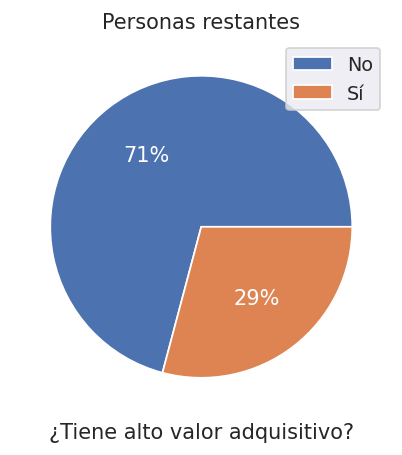

In [326]:
plt.figure(dpi=125)
df_aux = df_mc_16[df_mc_16.ganancia_perdida_declarada_bolsa_argentina < 5000]
df_aux['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"}
)
plt.legend(labels=['No','Sí'])
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.ylabel('')
plt.title("Personas restantes")
plt.show()

# Conclusión

Mediante nuestro analisis exploratorio de los datos hemos pudido entender cada uno de los datos y  cómo se relacionan entre sí para saber cuáles son los factores más importantes que determinan si un usuario tiene altos o bajos ingresos. 

Adicionalmente obtuvimos las siguientes conclusiones acerca del análisis:

*   El estado marital es muy relevante en el valor adquisitivo ya que si el estado marital de la persona no es *matrimonio_civil* tiende a no tener alto valor adquisitivo
*   Aquellas personas con *matrimonio_civil* y mas de 16 años estudiados tienden a tener alto valor adquisitivo
*   Aquellas personas con una ganancia de al menos 5000 tienden a tener alto valor adquisitivo
*   El barrio, religion, el trabajo y la categoria de trabajo no nos dice mucho acerca de los ingresos de la persona


Por otro lado, la resolución que se presenta de este trabajo practico es una de las varias posibles soluciones. Podríamos haber utilizado distintos tipos de gráficos para mostrar las relacionas, o bien mostrar otras. Tambien podríamos habernos hechos distintas preguntas como así tambien elegír distintos caminos a la hora de buscar las relaciones. Esto último podría habernos dirigido a distintas conclusiones, y por consecuente llegar a un distinto resultado de estimación. No obstante creemos que la solución que mostramos es un buen desarrollo y cumple con lo pedido. Decidimos no seguir añadiendo filtraciones en los datos, ya que la predicción solo mejoraba en unos decimales y queriamos evitar el overfitting del algoritmo

# Baseline

En base a nuestro análisis exploratorio de los datos y a las conclusiones mencionadas realizaremos un breve baseline que estime si una persona tendrá o no alto valor adquisitivo:

In [327]:
ANIOS_ESTUDIADOS = 16
GANACIA = 5000
def baseline_aux(row):
    if(row['estado_marital'] != "matrimonio_civil"):
        return False
    elif(row['anios_estudiados'] > ANIOS_ESTUDIADOS):
        return True
    elif(row['ganancia_perdida_declarada_bolsa_argentina'] >= GANACIA):
        return True
    else:
        return False

def baseline(df: pd.DataFrame):
  return  df.apply(lambda row: baseline_aux(row),axis='columns')

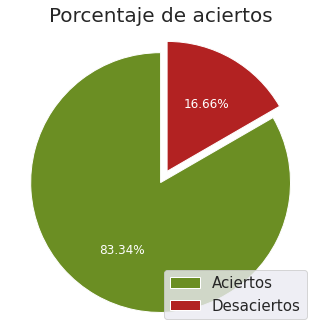

In [328]:
accuracy = accuracy_score(df.tiene_alto_valor_adquisitivo, baseline(df)).round(4)
sizes = [accuracy, 1 - accuracy]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(5.5,5.5))
ax1.pie(sizes, explode=explode, labels=None, autopct='%1.2f%%', textprops={'color':"w"}, startangle=90, colors=['olivedrab','firebrick'])
ax1.axis('equal')
plt.legend(labels=['Aciertos','Desaciertos'],loc = 'lower right', fontsize=15)
plt.ylabel('')
plt.title("Porcentaje de aciertos", fontsize=20)
plt.show() 